# Data Analysis - [`nlp-test-neoway`]

> This document contains the main findings regarding the behavior of the B2W-Reviews01 dataset, which contains features and data descriptive of product
reviews and with potential predictive capabilities.

### Summary
This corpus is a set of product reviews submitted to Americanas.com from January through May, 2018.

B2W-Reviews01 has both the review text and the meta-data related to each review: dates and times, 

ratings, geographical locations and ages of reviewers. 

## 1. Libraries

In [1]:
# Standard libs
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ydata_profiling import ProfileReport
import plotly.express as px
import joypy
import geopandas as gpd
from IPython.core.display import Markdown

sns.set_theme()
sns.set(palette="deep", color_codes=True)
pd.options.mode.chained_assignment = None # default='warn'

# Utilities

# DataPrep
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import re

# Modeling

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Overview of the data
### 2.1 Reading the data

In [2]:
df = pd.read_csv('../data/raw/B2W-Reviews01.csv')
df.head(5)

/tmp/ipykernel_190606/2255767118.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/B2W-Reviews01.csv')


submission_date                                        reviewer_id  \
0  2018-01-01 00:11:28  d0fb1ca69422530334178f5c8624aa7a99da47907c44de...   
1  2018-01-01 00:13:48  014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...   
2  2018-01-01 00:26:02  44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...   
3  2018-01-01 00:35:54  ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...   
4  2018-01-01 01:00:28  7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...   

  product_id                                       product_name  \
0  132532965  Notebook Asus Vivobook Max X541NA-GO472T Intel...   
1   22562178               Copo Acrílico Com Canudo 500ml Rocie   
2  113022329  Panela de Pressão Elétrica Philips Walita Dail...   
3  113851581               Betoneira Columbus - Roma Brinquedos   
4  131788803  Smart TV LED 43" LG 43UJ6525 Ultra HD 4K com C...   

    product_brand      site_category_lv1       site_category_lv2  \
0             NaN            Informática                Notebook   
1             NaN  Utilidades Domésticas  Copos, Taças e Canecas   
2  philips walita        Eletroportáteis         Panela Elétrica   
3     roma jensen             Brinquedos   Veículos de Brinquedo   
4              lg      TV e Home Theater                      TV   

                       review_title  overall_rating recommend_to_a_friend  \
0                               Bom               4                   Yes   
1  Preço imbatível, ótima qualidade               4                   Yes   
2      ATENDE TODAS AS EXPECTATIVA.               4                   Yes   
3        presente mais que desejado               4                   Yes   
4            Sem duvidas, excelente               5                   Yes   

                                         review_text  reviewer_birth_year  \
0  Estou contente com a compra entrega rápida o ú...               1958.0   
1  Por apenas R$1994.20,eu consegui comprar esse ...               1996.0   
2  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...               1984.0   
3  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...               1985.0   
4  A entrega foi no prazo, as americanas estão de...               1994.0   

  reviewer_gender reviewer_state  
0               F             RJ  
1               M             SC  
2               M             SP  
3               F             SP  
4               M             MG

In [3]:
df['submission_date'] = pd.to_datetime(df.submission_date, format='%Y-%m-%d %H:%M:%S')

### 2.2 Overview

In [4]:
# Utility functions to get an overview of the data

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (100*df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent (%)'])
    return missing_values[missing_values['Missing_Number']>0]

def oveview(df):
    print("Shape:", df.shape, '\n') 
    print('----------------------------------------')
    print(df.info(), '\n')
    print('----------------------------------------')
    print("Number of Uniques:\n", df.nunique(),'\n')
    print('----------------------------------------')
    print("Missing Values:\n", missing_values(df),'\n')
    print('----------------------------------------')
    print("All Columns:", list(df.columns),'\n')

In [5]:
oveview(df)

Shape: (132373, 14) 

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   submission_date        132373 non-null  datetime64[ns]
 1   reviewer_id            132373 non-null  object        
 2   product_id             132373 non-null  object        
 3   product_name           132289 non-null  object        
 4   product_brand          40982 non-null   object        
 5   site_category_lv1      132367 non-null  object        
 6   site_category_lv2      128360 non-null  object        
 7   review_title           132071 non-null  object        
 8   overall_rating         132373 non-null  int64         
 9   recommend_to_a_friend  132355 non-null  object        
 10  review_text            129098 non-null  object        
 11  reviewer_birth_year    126389 non-null  f

In [6]:
df.describe(include='all', datetime_is_numeric=True)

submission_date  \
count                          132373   
unique                            NaN   
top                               NaN   
freq                              NaN   
mean    2018-03-16 22:51:34.101742848   
min               2018-01-01 00:11:28   
25%               2018-01-29 07:57:00   
50%               2018-03-22 05:48:28   
75%               2018-04-24 08:47:25   
max               2018-05-31 23:50:33   
std                               NaN   

                                              reviewer_id   product_id  \
count                                              132373     132373.0   
unique                                             112993      55930.0   
top     6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...  128010777.0   
freq                                                  155        428.0   
mean                                                  NaN          NaN   
min                                                   NaN          NaN   
25%                                                   NaN          NaN   
50%                                                   NaN          NaN   
75%                                                   NaN          NaN   
max                                                   NaN          NaN   
std                                                   NaN          NaN   

                                             product_name product_brand  \
count                                              132289         40982   
unique                                              47363          1062   
top     Smartphone Motorola Moto G 5S Dual Chip Androi...       samsung   
freq                                                  792          6015   
mean                                                  NaN           NaN   
min                                                   NaN           NaN   
25%                                                   NaN           NaN   
50%                                                   NaN           NaN   
75%                                                   NaN           NaN   
max                                                   NaN           NaN   
std                                                   NaN           NaN   

              site_category_lv1 site_category_lv2 review_title  \
count                    132367            128360       132071   
unique                       54               713        56555   
top     Celulares e Smartphones        Smartphone    Muito bom   
freq                      20859             17679         3018   
mean                        NaN               NaN          NaN   
min                         NaN               NaN          NaN   
25%                         NaN               NaN          NaN   
50%                         NaN               NaN          NaN   
75%                         NaN               NaN          NaN   
max                         NaN               NaN          NaN   
std                         NaN               NaN          NaN   

        overall_rating recommend_to_a_friend  \
count    132373.000000                132355   
unique             NaN                     2   
top                NaN                   Yes   
freq               NaN                 96368   
mean          3.492004                   NaN   
min           1.000000                   NaN   
25%           2.000000                   NaN   
50%           4.000000                   NaN   
75%           5.000000                   NaN   
max           5.000000                   NaN   
std           1.530289                   NaN   

                                              review_text  \
count                                              129098   
unique                                             126724   
top     Entrega super rápida .   Parabéns pela agilida...   
freq                                                   57   
mean                                                  NaN   
min

**Insights from Overview:**
- ~ 70% null entries for 'product_brand'
- Number of different product_id and product_name are different, maybe there is some mistake in this labelling 
- ~ 2,5% didn't write review_text but only 0,22% didn't write review_title
- Most important structured features apparently: *site_category_lv1, overall_rating, recommend_to_a_friend, reviewer_birth_year, reviewer_gender, reviewer_state*
- Only overall_rating and reviewer_birth_year are numerical features
- Only 5 months of data

**Decision Making:**
- 'reviewer_id' and 'product_id' will be ignored since they are database ids
- 'product_brand' probably doesn't worth deeply evaluating

In [7]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Cleaning data:**
- duplicate rows
- reviewer_birth_year has wrong entries

### 2.3 Basic data cleaning data for features investigation

In [8]:
df_features = df.copy()
df_features.reviewer_birth_year.describe()

count    126389.000000
mean       1977.495898
std          21.895265
min          59.000000
25%        1969.000000
50%        1980.000000
75%        1987.000000
max        2018.000000
Name: reviewer_birth_year, dtype: float64

In [9]:
# Clean wrong birth_year entries

df_features = df_features[(df_features['reviewer_birth_year'] > 1900) | pd.isna(df_features['reviewer_birth_year'])] 
print(df_features.reviewer_birth_year.describe()) 

df_features_shape = df_features.shape[0]
print('\n', '----------------------------------------', '\n')
print(f'Number of rows removed: {df.shape[0] - df_features_shape}')

count    126355.000000
mean       1977.675692
std          12.772624
min        1905.000000
25%        1969.000000
50%        1980.000000
75%        1987.000000
max        2018.000000
Name: reviewer_birth_year, dtype: float64

 ---------------------------------------- 

Number of rows removed: 34


In [10]:
# Clean duplicates

df_features.drop_duplicates(inplace=True)
print(f'Number of rows removed: {df_features_shape - df_features.shape[0]}')

Number of rows removed: 955


## 3. Exploratory Data Analysis
#### 3.1 Coverage of problem's scope

Describe whether your datasets contain enough samples in regions of the space that can cover the entire problem scope.

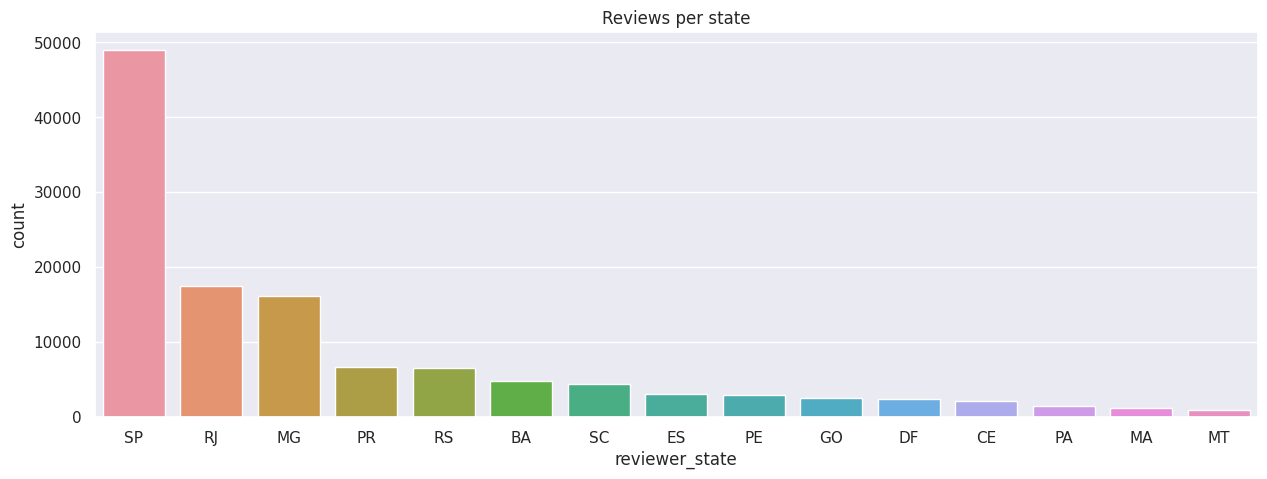

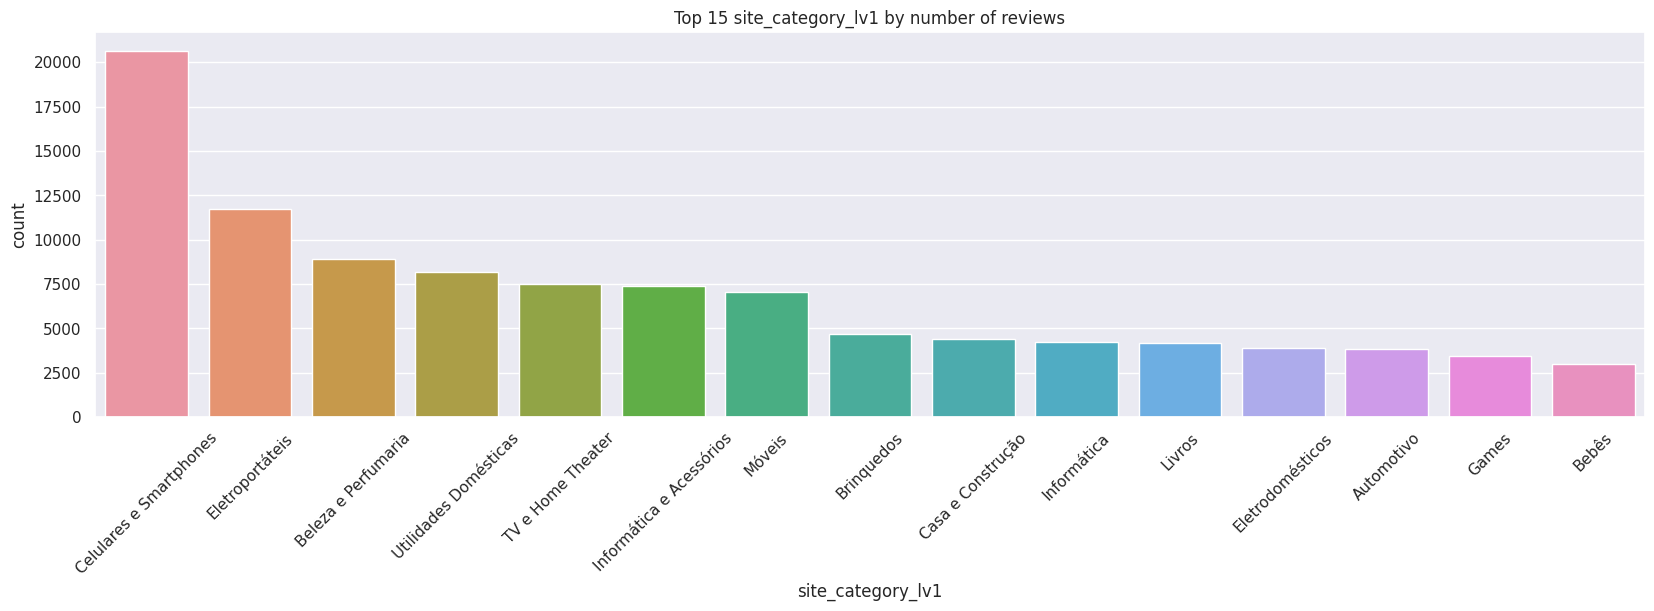

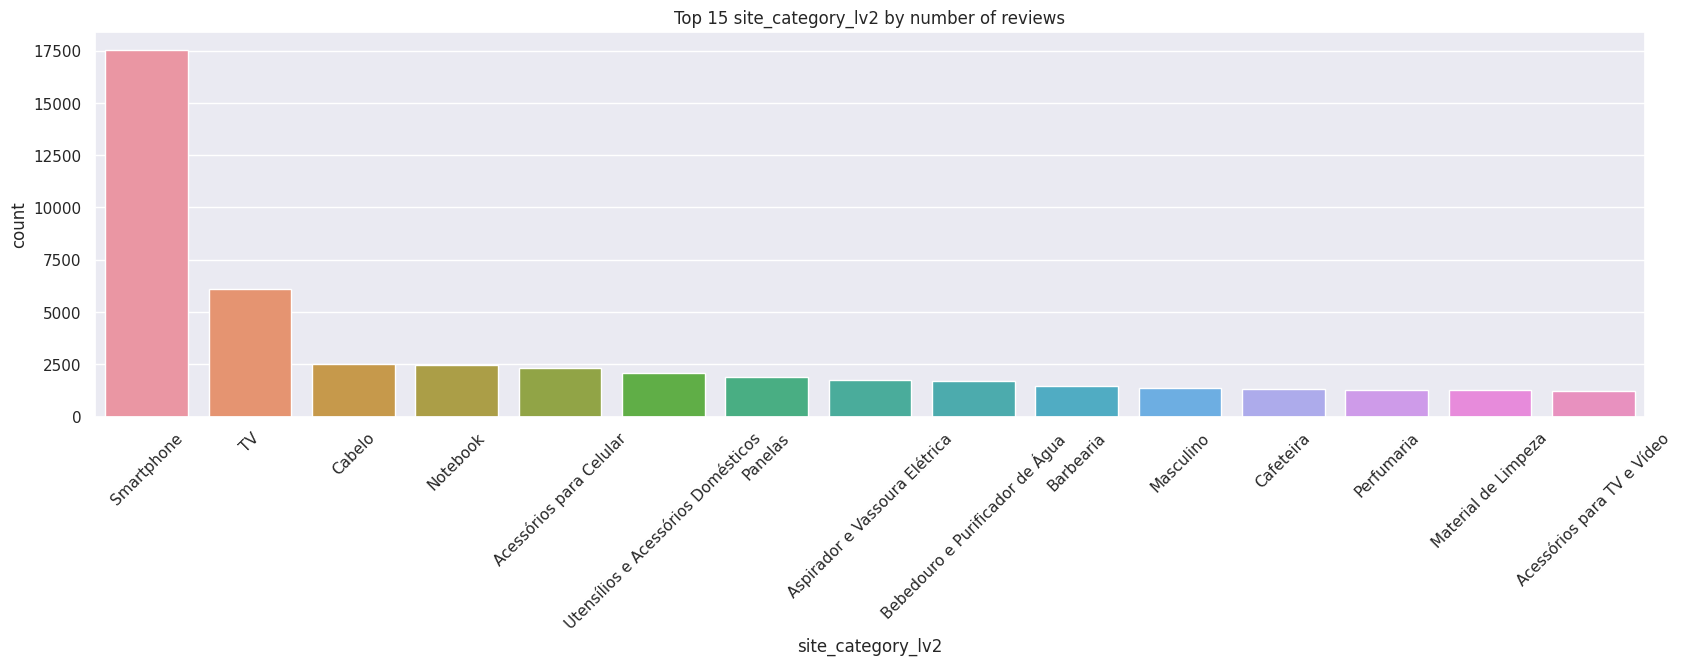

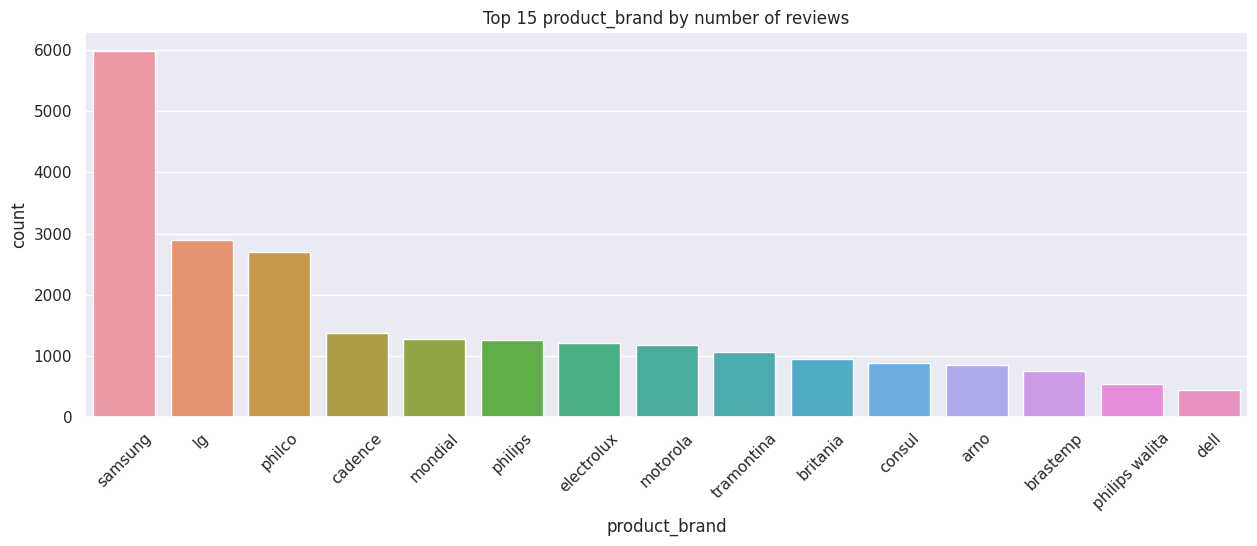

In [11]:
def plot_ranking(df, column, title, rotate=True, number_of_values=15, figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize) 
    # drawing the plot
    sns.countplot(x=column,
                data=df,
                order=df[column].value_counts().iloc[:number_of_values].index, 
                ax=ax).set(title=title)
    if rotate:
        plt.xticks(rotation=45)
    plt.show()

plot_ranking(df_features, 'reviewer_state', 'Reviews per state', rotate=False)
plot_ranking(df_features, 'site_category_lv1', 'Top 15 site_category_lv1 by number of reviews', figsize=(20, 5))
plot_ranking(df_features, 'site_category_lv2', 'Top 15 site_category_lv2 by number of reviews', figsize=(20, 5))
plot_ranking(df_features, 'product_brand', 'Top 15 product_brand by number of reviews')

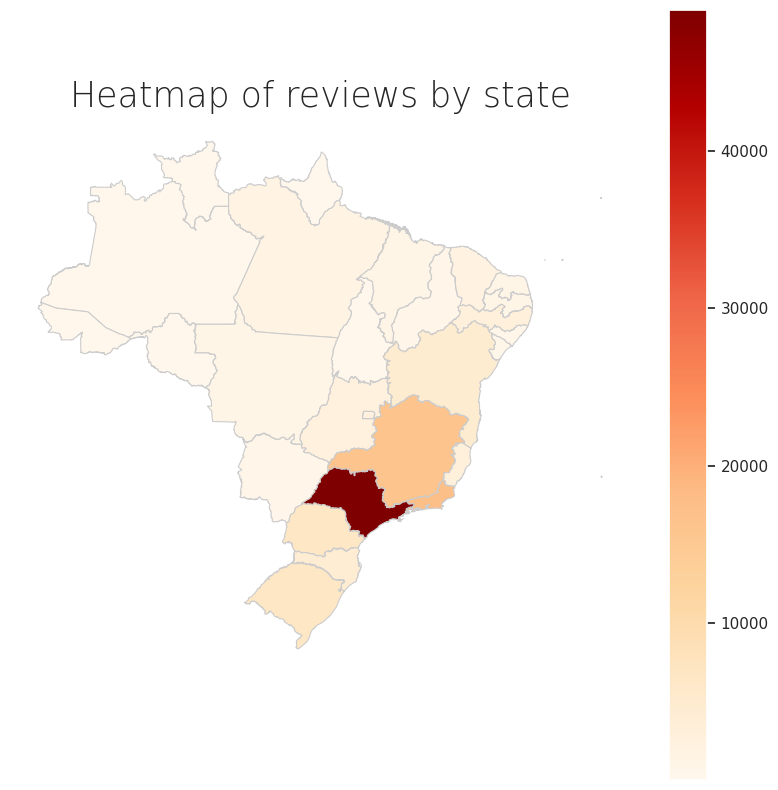

In [12]:
# Add file with map
shapefile_path = '../data/utils/bcim_2016_21_11_2018.gpkg'
brazil_states = gpd.read_file(shapefile_path, layer='lim_unidade_federacao_a')
states = pd.DataFrame(df_features['reviewer_state'].value_counts().sort_index())

def plot_heatmap(df_data, column, title, shapefile=brazil_states):
    # Create dataframe with the count of review per state
    data_with_states = shapefile.merge(df_data, left_on="sigla", right_on=df_data.index)
    fig, ax = plt.subplots(figsize=(10, 10))
    data_with_states.plot(column=column, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.axis('off')

    # Add a title to the plot
    plt.title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    plt.show()

plot_heatmap(states, column='reviewer_state', title='Heatmap of reviews by state')

In [13]:
# Share of Smartphone reviews from the website

smartphone_reviews = df_features['site_category_lv2'].value_counts().loc['Smartphone']
total_reviews = len(df_features)

print(f'Smartphone reviews represent {smartphone_reviews/total_reviews*100:.2f}% of the total reviews from the website') 

Smartphone reviews represent 13.34% of the total reviews from the website


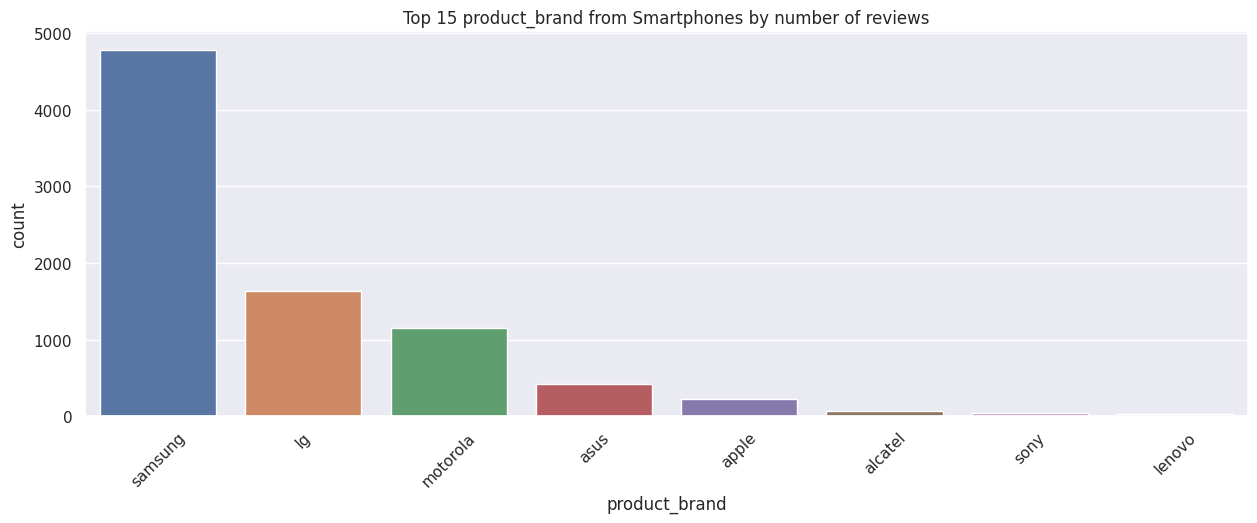

In [14]:
# Print top product_brand inside "Smartphone"

data_smarts = df_features[df_features['site_category_lv2'] == 'Smartphone']
plot_ranking(data_smarts, 'product_brand', 'Top 15 product_brand from Smartphones by number of reviews', number_of_values=8)

In [15]:
# representativeness of product_brand from 'Smartphones' 
missing_number = data_smarts.isnull().sum().sort_values(ascending=False)
missing_percent = 100*missing_number.loc['product_brand']/len(data_smarts)
print(f'product_brand is missing in {missing_percent:.2f}% of the reviews from Smartphones')

# Share of product_brand from 'Smartphones' 
samsung_smart_reviews = data_smarts['product_brand'].value_counts().loc['samsung']
valid_reviews = len(data_smarts) - missing_number.loc['product_brand']
print(f'Samsung reviews represent {samsung_smart_reviews/valid_reviews*100:.2f}% of the total valid reviews from Smartphones')


product_brand is missing in 51.93% of the reviews from Smartphones
Samsung reviews represent 56.77% of the total valid reviews from Smartphones


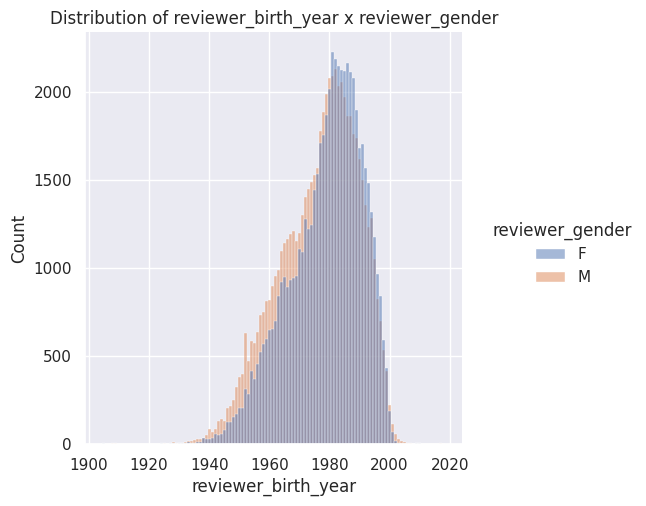

In [16]:
sns.displot(data=df_features, 
            x="reviewer_birth_year", 
            hue='reviewer_gender', 
            discrete=True).set(title='Distribution of reviewer_birth_year x reviewer_gender')

In [17]:
# Calculate men/women ratio
df_men = df_features[df_features['reviewer_gender'] == 'M']
total_sex_df = df_features['reviewer_gender'].notnull().sum()
print(f'Men represent {len(df_men)/total_sex_df*100:.2f}% of the total reviews')

# Calculate age average
men_age_avg = df_features[df_features['reviewer_gender'] == 'M']['reviewer_birth_year'].mean()
women_age_avg = df_features[df_features['reviewer_gender'] == 'F']['reviewer_birth_year'].mean()
print(f'Average birth year of men reviewers is {round(men_age_avg, 2)} while women is {round(women_age_avg, 2)} ')

Men represent 51.56% of the total reviews
Average birth year of men reviewers is 1976.59 while women is 1978.79 


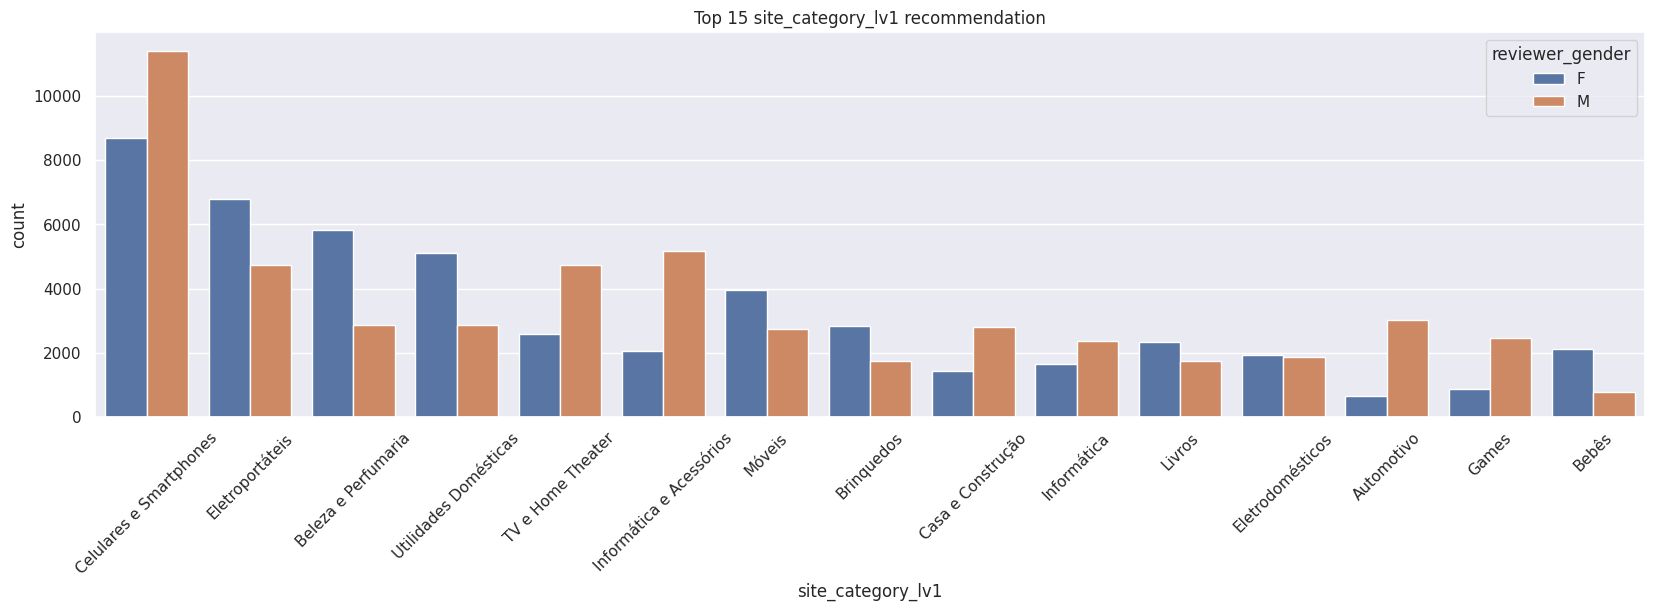

In [18]:
# Print top categories
fig, ax = plt.subplots(figsize=(20, 5))
 
# drawing the plot
sns.countplot(x='site_category_lv1', 
              data=df_features, 
              hue='reviewer_gender', 
              order=df_features.site_category_lv1.value_counts().iloc[:15].index, 
              ax=ax).set(title='Top 15 site_category_lv1 recommendation')
plt.xticks(rotation=45)
plt.show()

**Insights:**
- Reviews are concentrated in *SP*, logarithmically decreasing in other states (3% of data NaN)
    - There is a cluster of most reviews in the south and southeast regions
- Reviews are concentrated in *Celulares e Smartphones*, **slowly** decreasing in other site_category_lv1 (0.004% of data NaN)
- Reviews are concentrated in *Smartphones*, decreasing in other site_category_lv2 (3% of data NaN)
    - Smartphone reviews represent 13.34% of the total reviews from the website
- Reviews are concentrated in *Samsung*, logarithmically decreasing in other product_brand (70% of data NaN)
    - Samsung reviews represent 56.71% of the total valid reviews from Smartphones (52% of data NaN)
- Men represent a slightly bigger population the women
- Women reviewers are in average 2 years younger than men reviewers
- The reviewer_gender can strongly vary across categories

### 3.2. Target (Y) variable analysis 

*Check proportion of the target class:* 

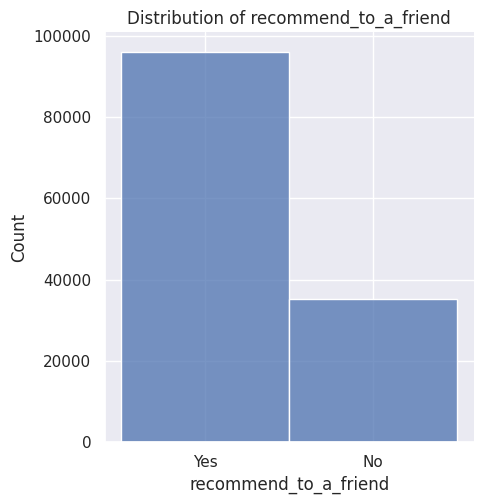

In [19]:
sns.displot(data=df_features, x="recommend_to_a_friend", discrete=True).set(title='Distribution of recommend_to_a_friend')

[Text(0.5, 1.0, 'Distribution of age x rating x recommended_ind')]

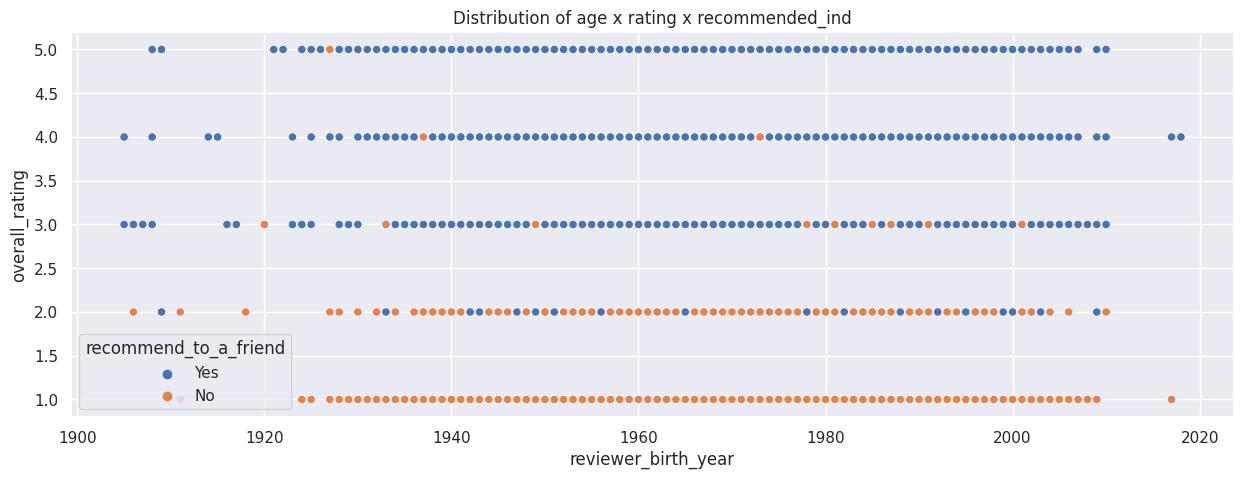

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(data=df_features, x="reviewer_birth_year", y="overall_rating", hue="recommend_to_a_friend").set(title='Distribution of age x rating x recommended_ind')

**Insigths:**
- Imbalanced dataset, where "Recommended" values are more dominating than "Not Recommended"
- From the profiling was clear that recommend_to_a_friend and overall_rating had a big correlation (~0.9)

### 3.3 Persona Analysis

Describing patterns and profiles about overall reviews and also clusters of detractors and promoters

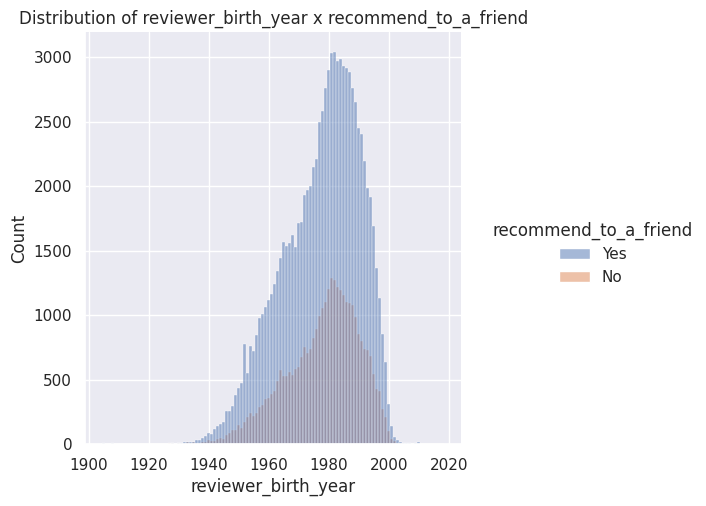

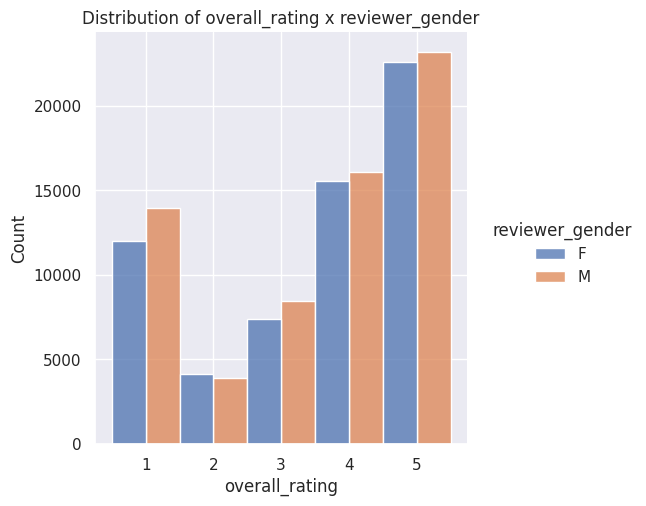

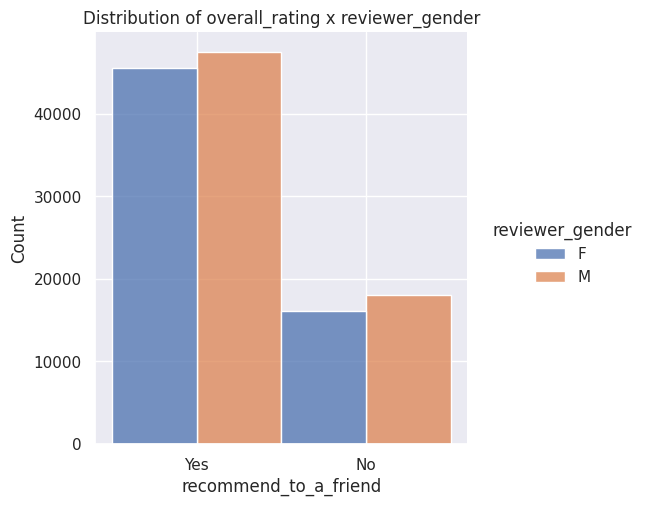

In [21]:
sns.displot(data=df_features, 
            x="reviewer_birth_year", 
            hue='recommend_to_a_friend', 
            discrete=True).set(title='Distribution of reviewer_birth_year x recommend_to_a_friend')
sns.displot(data=df_features, 
            x="overall_rating", 
            hue='reviewer_gender', 
            multiple="dodge", 
            discrete=True).set(title='Distribution of overall_rating x reviewer_gender')
sns.displot(data=df_features, 
            x="recommend_to_a_friend", 
            hue='reviewer_gender', 
            multiple="dodge", 
            discrete=True).set(title='Distribution of overall_rating x reviewer_gender')

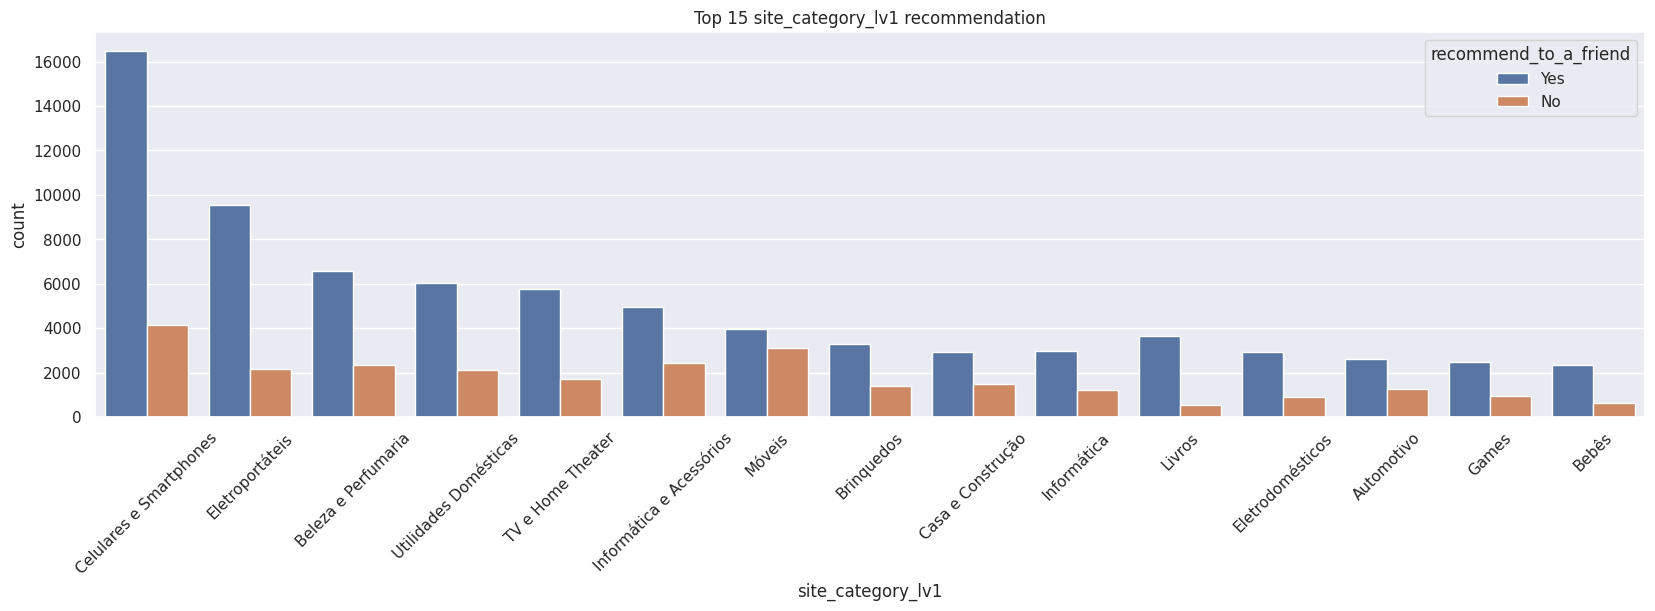

In [22]:
# Print top categories
fig, ax = plt.subplots(figsize=(20, 5))
 
# drawing the plot
sns.countplot(x='site_category_lv1', 
              data=df_features, 
              hue='recommend_to_a_friend', 
              order=df_features.site_category_lv1.value_counts().iloc[:15].index, 
              ax=ax).set(title='Top 15 site_category_lv1 recommendation')
plt.xticks(rotation=45)
plt.show()

**Insights:**
- The distribution of 'recomendation' looks pretty similar regarding age and sex
- However, the distribution of sentiment is not linear in the categories. Visually, "Móveis" has almost 50% of approval while livros has 90%

Creation of a sentiment feature, which is calculated by the (positive recommendation)/(total recommendation) in a subset

In [23]:
# Obtain the sentiment for each category based on the positive reviews / total reviews
def create_sentiment(df, column):
    no_df = df.loc[df['recommend_to_a_friend'] == 'No', column].value_counts().to_frame()
    yes_df = df.loc[df['recommend_to_a_friend'] == 'Yes', column].value_counts().to_frame()
    df_recom = pd.merge(no_df, yes_df, left_index=True, right_index=True, suffixes=('_no', '_yes'))
    df_recom['sentiment'] = df_recom[column+'_yes'] / (df_recom[column+'_yes'] + df_recom[column+'_no'])
    df_recom.sort_values(by='sentiment', ascending=False, inplace=True)
    df_recom['total'] = df_recom[column+'_yes'] + df_recom[column+'_no']
    return df_recom

df_site_category_lv1_recom = create_sentiment(df_features, 'site_category_lv1')
df_site_category_lv1_recom.head()

site_category_lv1_no  site_category_lv1_yes  sentiment  \
Filmes e Séries                      59                    535   0.900673   
Livros                              533                   3649   0.872549   
Livros Importados                    11                     70   0.864198   
Música                               39                    217   0.847656   
Artigos de Festa                      1                      5   0.833333   

                   total  
Filmes e Séries      594  
Livros              4182  
Livros Importados     81  
Música               256  
Artigos de Festa       6

In [24]:
df_site_category_lv1_recom.sentiment.describe() 

count    50.000000
mean      0.696293
std       0.103159
min       0.482456
25%       0.655657
50%       0.711630
75%       0.747137
max       0.900673
Name: sentiment, dtype: float64

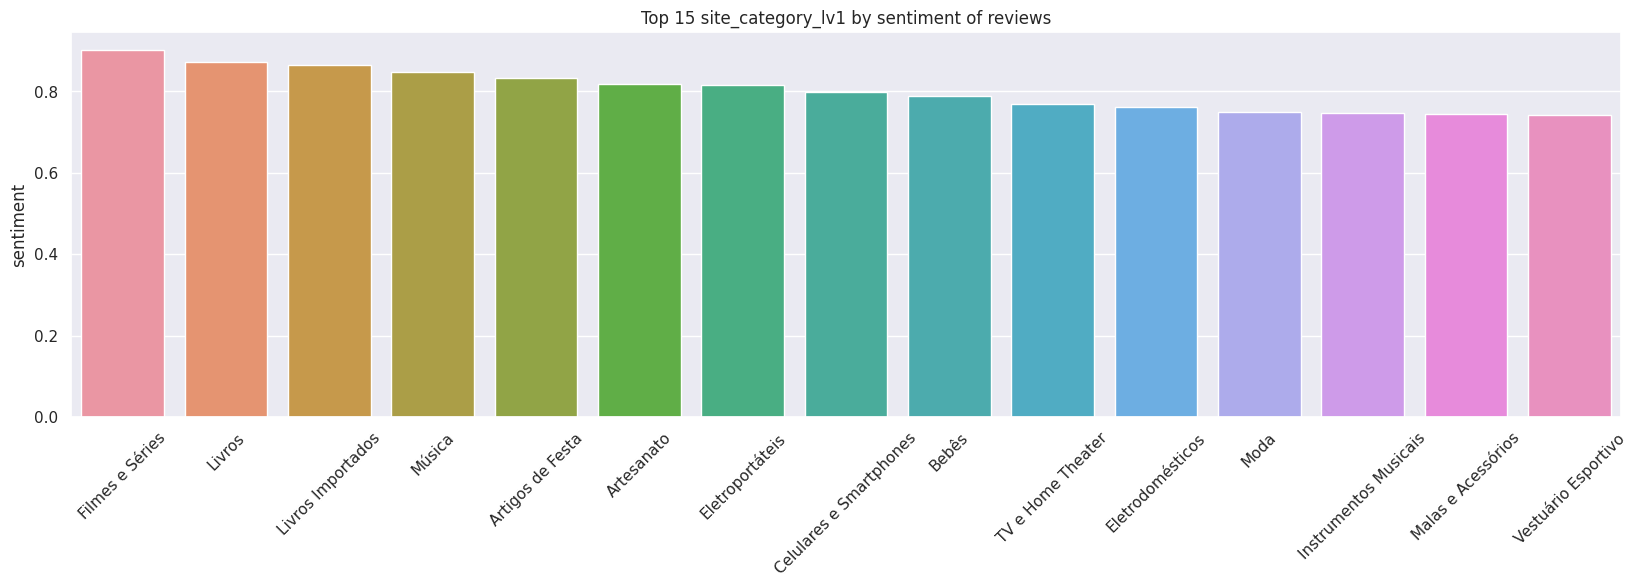

In [25]:
# Print top categories 
fig, ax = plt.subplots(figsize=(20, 5))
 
# drawing the plot
sns.barplot(data=df_site_category_lv1_recom,
            x=df_site_category_lv1_recom.index,
            y="sentiment",
            order=df_site_category_lv1_recom.sentiment.iloc[:15].index, 
            ax=ax).set(title='Top 15 site_category_lv1 by sentiment of reviews')
plt.xticks(rotation=45)
plt.show()

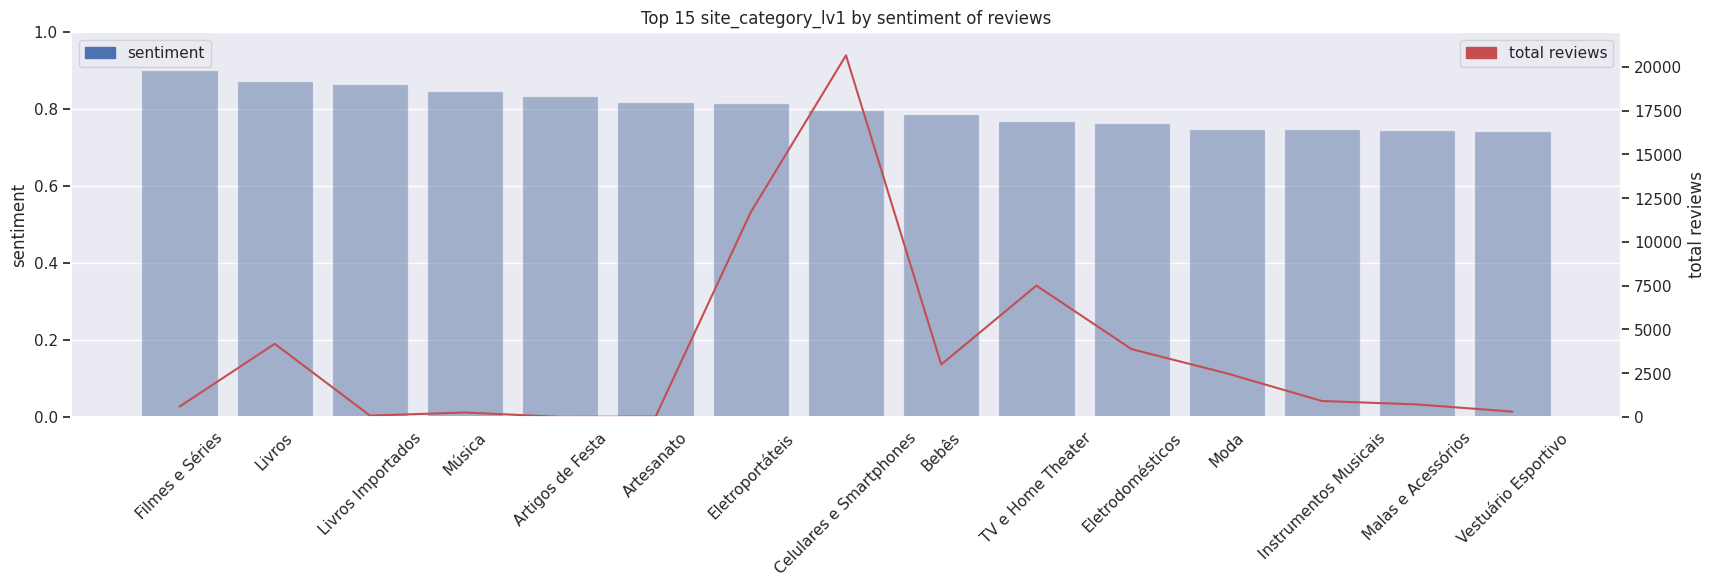

In [26]:
df_top_sentiment = df_site_category_lv1_recom[df_site_category_lv1_recom.index.isin(df_site_category_lv1_recom.sentiment.iloc[:15].index)]

def plot_sentiment(df, title, hue=None):
    fig, ax1 = plt.subplots(figsize=(20, 5))
    # plot line graph on axis #1
    ax1 = sns.barplot(
        x=df.index, 
        y='sentiment', 
        data=df,
        hue=hue,
        color='b',
        alpha=0.5
    )
    ax1.set_ylabel('sentiment')
    ax1.set_ylim(0, 1)
    ax1_patch = mpatches.Patch(color='b', label='sentiment')
    ax1.legend(handles=[ax1_patch], loc="upper left")
    # set up the 2nd axis
    ax1.tick_params('x', labelrotation=45)
    ax2 = ax1.twinx()
    # plot bar chart on axis #2
    sns.lineplot(
        x=df.index, 
        y='total', 
        data=df, 
        color='r',
    )
    ax2.set_ylabel('total reviews')
    ax2.set_ylim(0, 22000)
    ax2.grid(False)
    ax2_patch = mpatches.Patch(color='r', label='total reviews')
    ax2.legend(handles=[ax2_patch], loc="upper right")
    plt.title(title)
    plt.show()

plot_sentiment(df_top_sentiment, 'Top 15 site_category_lv1 by sentiment of reviews')

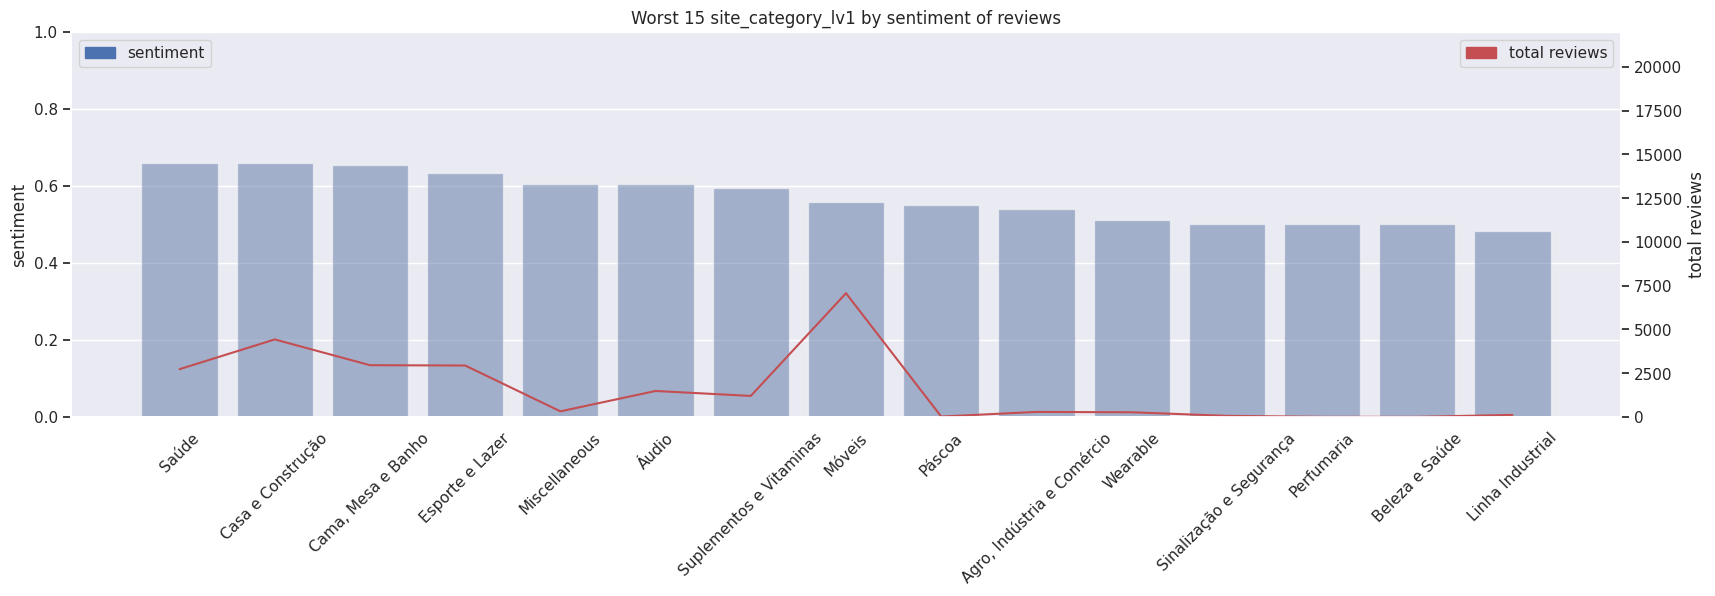

In [27]:
df_worst_sentiment = df_site_category_lv1_recom[df_site_category_lv1_recom.index.isin(df_site_category_lv1_recom.sentiment.iloc[-15:].index)]
plot_sentiment(df_worst_sentiment, 'Worst 15 site_category_lv1 by sentiment of reviews')

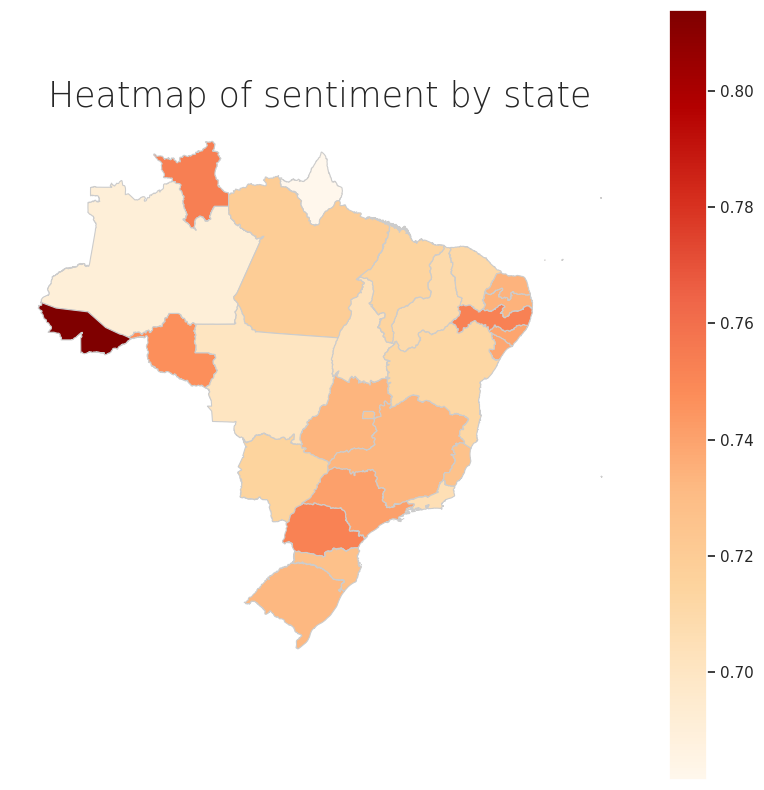

In [28]:
states_sentiment = create_sentiment(df_features, 'reviewer_state')
plot_heatmap(states_sentiment, column='sentiment', title='Heatmap of sentiment by state')

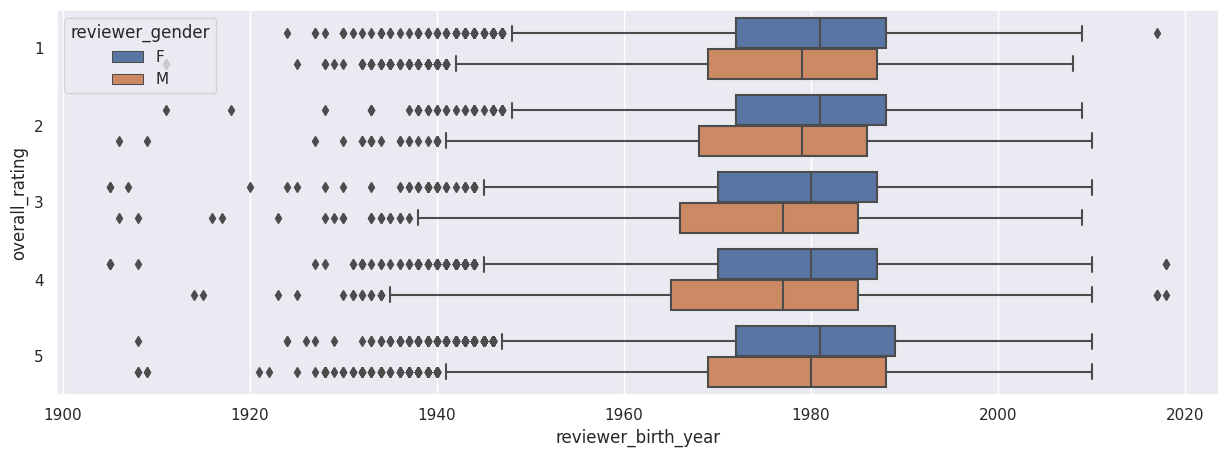

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="reviewer_birth_year", y="overall_rating",
            hue="reviewer_gender", orient="h",
            data=df_features)

plt.show()

**Insights:**
- Despite the close number of men and women reviewing, in the average men are older than women
- Younger people tend to have more extreme opinions
- Eletroportateis, Celulares e Smartphones, Eletrodomésticos, Livros e Bebês are promoters
- Móveis, Casa e Construção, Esporte e Lazer are detractors

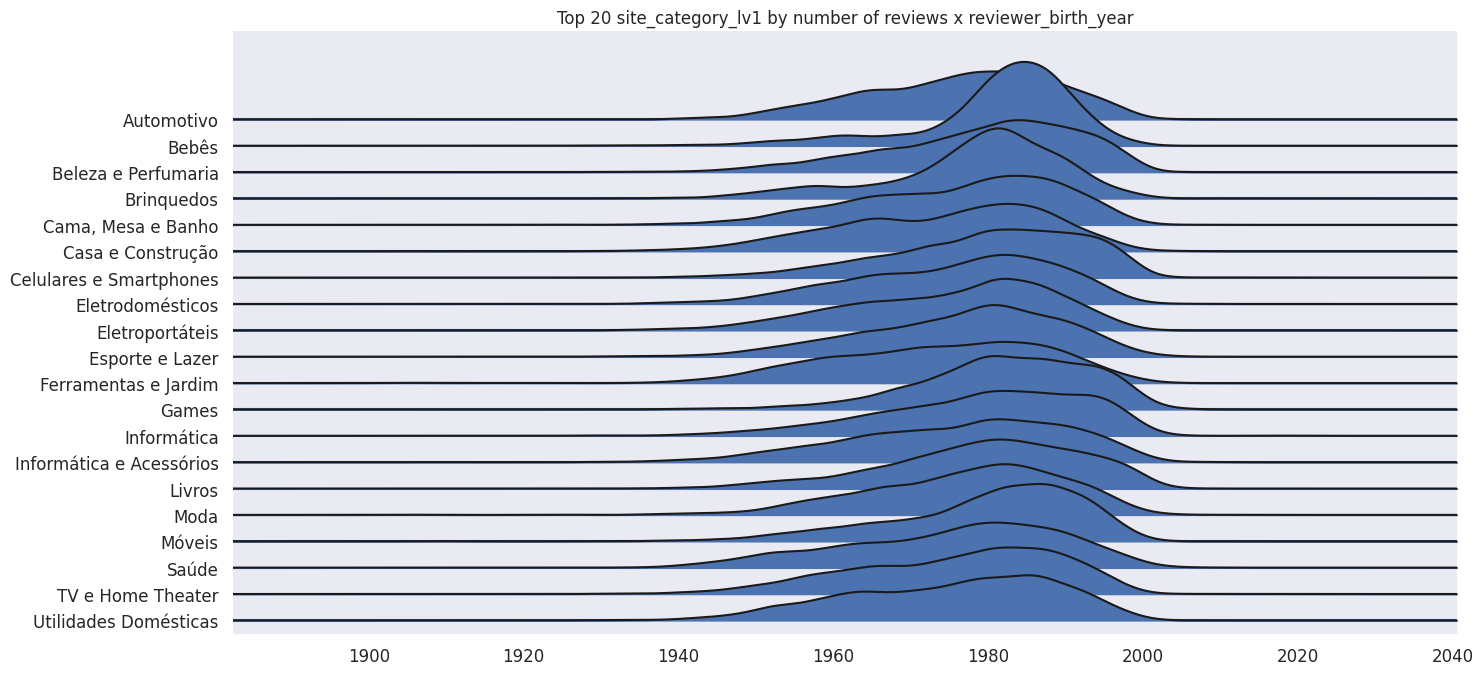

In [30]:
df_top_reviews = df_features[df_features.site_category_lv1.isin(df_features.site_category_lv1.value_counts().iloc[:20].index)]
fig, axes = joypy.joyplot(df_top_reviews, 
                          column="reviewer_birth_year", 
                          by="site_category_lv1",
                          overlap=1, 
                          figsize=(15, 7), 
                          title='Top 20 site_category_lv1 by number of reviews x reviewer_birth_year')

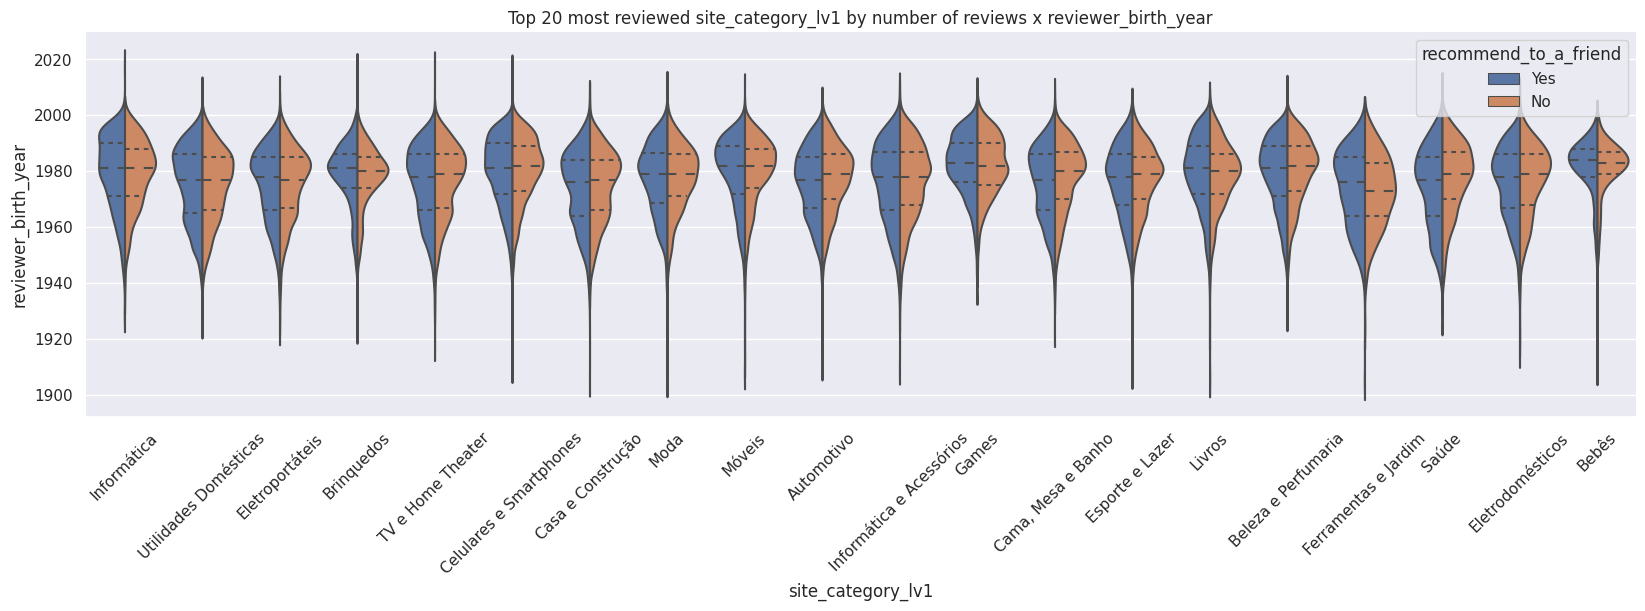

In [31]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.violinplot(x="site_category_lv1", y="reviewer_birth_year",  hue="recommend_to_a_friend",
               split=True, inner="quart",
               data=df_top_reviews).set(title='Top 20 most reviewed site_category_lv1 by number of reviews x reviewer_birth_year')
sns.despine(left=True)
plt.xticks(rotation=45)
plt.show()

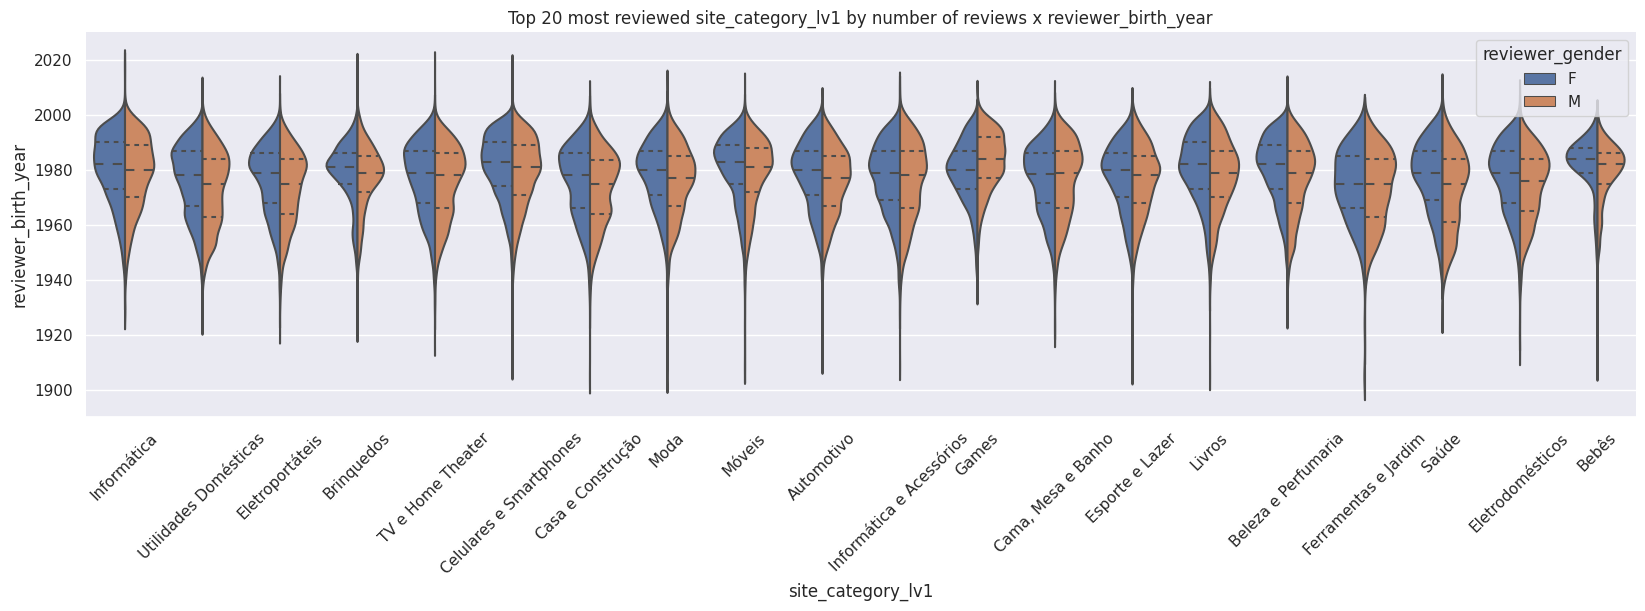

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.violinplot(x="site_category_lv1", y="reviewer_birth_year",  hue="reviewer_gender",
               split=True, inner="quart",
               data=df_top_reviews).set(title='Top 20 most reviewed site_category_lv1 by number of reviews x reviewer_birth_year')
sns.despine(left=True)
plt.xticks(rotation=45)
plt.show()

**Insigths:**
- Some categories have a concentrated age of reviewers.
    - Categories with younger reviewers: 'Brinquedos', 'Games', 'Bebês'
- In some categoreis the sentiment varies with age: 'Case, Mesa e Banho', 'Ferramentas e Jardim', Saúde 

## 3.4 Timeseries Analysis

In [33]:
df_features['date'] = df_features['submission_date'].dt.date
by_date = pd.Series(df_features['date']).value_counts().sort_index()
by_date.index = pd.DatetimeIndex(by_date.index)
df_date = by_date.rename_axis('date').reset_index(name='counts')
df_date.index = df_date['date']
df_date.drop(columns=['date'], inplace=True)
df_date['pos_recom'] = df_features[df_features['recommend_to_a_friend']=='Yes']['date'].value_counts().sort_index()
df_date['neg_recom'] = df_features[df_features['recommend_to_a_friend']=='No']['date'].value_counts().sort_index()

In [34]:
fig = px.line(df_date, x=df_date.index, y=['pos_recom', 'neg_recom'], title='Number of reviews by date')
fig.show()

## 4. Text Analysis
### 4.1 Overview

In [35]:
FreqOfWords = df['review_text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (Before Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

### 4.2 Data Cleaning

In [36]:
df_text = df_features.copy()

# Basic cleaning
cols_delete = ['submission_date', 'reviewer_id', 'product_id', 'product_name', 'product_brand']
df_text.drop(columns=cols_delete, inplace=True)
df_text.dropna(inplace=True)
df_text.reset_index(drop=True, inplace=True)

# Get length of text
df_text['text_len'] = df_text['review_text'].astype(str).apply(len)
df_text['title_len'] = df_text['review_title'].astype(str).apply(len)

print('Percentage of reviews after cleaning: {} %'.format(100*len(df_text)/len(df_features)))

Percentage of reviews after cleaning: 90.18069171284175 %


In [37]:
# Apply  regex

def apply_regex(corpus, regex):
    # corpus = corpus.apply(lambda x: re.sub(regex, ' ', x))
    corpus = [re.sub(regex, ' ', x) for x in corpus]
    return corpus

def multiple_regex(corpus, regex_list):
    # Lowcase
    corpus = corpus.apply(lambda x: x.lower())
    # Negation
    corpus = [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in corpus]
    # Basix regex
    for regex in regex_list:
        corpus = apply_regex(corpus, regex)
    return corpus

# Handle Sites and Hiperlinks, numbers, special characters, additional whitespaces
regex_list = [r'www\S+', r'http\S+', r'@\S+', r'#\S+', r'[0-9]+', r'\W', r'\s+', r'[ \t]+$']
columns = ['review_text', 'review_title']
for column in columns:
    df_text[column] = multiple_regex(df_text[column], regex_list)
df_text.head()

site_category_lv1       site_category_lv2  \
0            Informática                Notebook   
1  Utilidades Domésticas  Copos, Taças e Canecas   
2        Eletroportáteis         Panela Elétrica   
3             Brinquedos   Veículos de Brinquedo   
4      TV e Home Theater                      TV   

                      review_title  overall_rating recommend_to_a_friend  \
0                              bom               4                   Yes   
1  preço imbatível ótima qualidade               4                   Yes   
2     atende todas as expectativa                4                   Yes   
3       presente mais que desejado               4                   Yes   
4            sem duvidas excelente               5                   Yes   

                                         review_text  reviewer_birth_year  \
0  estou contente com a compra entrega rápida o ú...               1958.0   
1  por apenas r eu consegui comprar esse lindo co...               1996.0   
2  supera em agilidade e praticidade outras panel...               1984.0   
3  meu filho amou parece de verdade com tantos de...               1985.0   
4  a entrega foi no prazo as americanas estão de ...               1994.0   

  reviewer_gender reviewer_state        date  text_len  title_len  
0               F             RJ  2018-01-01       158          3  
1               M             SC  2018-01-01        69         32  
2               M             SP  2018-01-01       236         28  
3               F             SP  2018-01-01        62         26  
4               M             MG  2018-01-01       202         22

In [38]:
# Visualize single review

display(Markdown('> '+df_text['review_text'][11]))

> produto de acordo com o que eu esperava somente o prazo de entrega que ficou um pouco a desejar um pouco longo

In [39]:
# Check for the existence of NaN values in a cell:
df_text.isnull().sum()

site_category_lv1        0
site_category_lv2        0
review_title             0
overall_rating           0
recommend_to_a_friend    0
review_text              0
reviewer_birth_year      0
reviewer_gender          0
reviewer_state           0
date                     0
text_len                 0
title_len                0
dtype: int64

In [40]:
print(df_text['title_len'].describe(),'\n')
print(df_text['text_len'].describe())

count    118483.000000
mean         18.553852
std          13.617120
min           1.000000
25%          10.000000
50%          16.000000
75%          23.000000
max         150.000000
Name: title_len, dtype: float64 

count    118483.000000
mean        135.603175
std         123.357746
min          50.000000
25%          68.000000
50%          95.000000
75%         154.000000
max        4134.000000
Name: text_len, dtype: float64


In [41]:
df_text[df_text['title_len']==1]

site_category_lv1        site_category_lv2 review_title  \
1240    Informática e Acessórios          Projetor e Tela                
1310                      Móveis           Sala de Jantar                
1448                      Móveis                     Mesa                
1450                      Móveis          Quarto Completo                
1763                 Informática                 Notebook                
...                          ...                      ...          ...   
116323   Celulares e Smartphones  Acessórios para Celular                
117640       Beleza e Perfumaria                   Cabelo            ó   
117746                     Bebês            Banho do bebê                
118342   Celulares e Smartphones  Acessórios para Celular                
118345   Celulares e Smartphones  Acessórios para Celular                

        overall_rating recommend_to_a_friend  \
1240                 5                   Yes   
1310                 2                    No   
1448                 1                    No   
1450                 3                   Yes   
1763                 1                    No   
...                ...                   ...   
116323               2                   Yes   
117640               5                   Yes   
117746               4                   Yes   
118342               4                   Yes   
118345               4                   Yes   

                                              review_text  \
1240                                                        
1310     negação recebi ainda negação chegou ainda meu...   
1448     negação gostei acabamento muito ruim madeira ...   
1450    eu ameiii o produto pena que veio com o espelh...   
1763     negação recebi o produto porque fui enrolada ...   
...                                                   ...   
116323  o relogio gerar chip dz negação chegou negação...   
117640  comprei o kit e só chegou a progressiva faltou...   
117746                                                      
118342  produto de excelente qualidade super recomendo...   
118345  produto de excelente qualidade super recomendo...   

        reviewer_birth_year reviewer_gender reviewer_state        date  \
1240                 1983.0               M             PR  2018-01-02   
1310                 1980.0               M             SP  2018-01-02   
1448                 1958.0               F             DF  2018-01-02   
1450                 1996.0               F             RJ  2018-01-02   
1763                 1999.0               F             ES  2018-01-02   
...                     ...             ...            ...         ...   
116323               1990.0               F             AM  2018-05-28   
117640               1981.0               F             BA  2018-05-30   
117746               1977.0               M             RJ  2018-05-30   
118342               1980.0               M             MG  2018-05-31   
118345               1980.0               M             MG  2018-05-31   

        text_len  title_len  
1240          51          1  
1310          66          1  
1448         113          1  
1450          59          1  
1763          57          1  
...          ...        ...  
116323       116          1  
117640       202          1  
117746       136          1  
118342        95          1  
118345        71          1  

[238 rows x 12 columns]

In [42]:
len(df_text[df_text['title_len']==1])

238

Later check if still are texts of only spaces after adding review_text and review_title

### 4.3 Exploratory Data Analysis

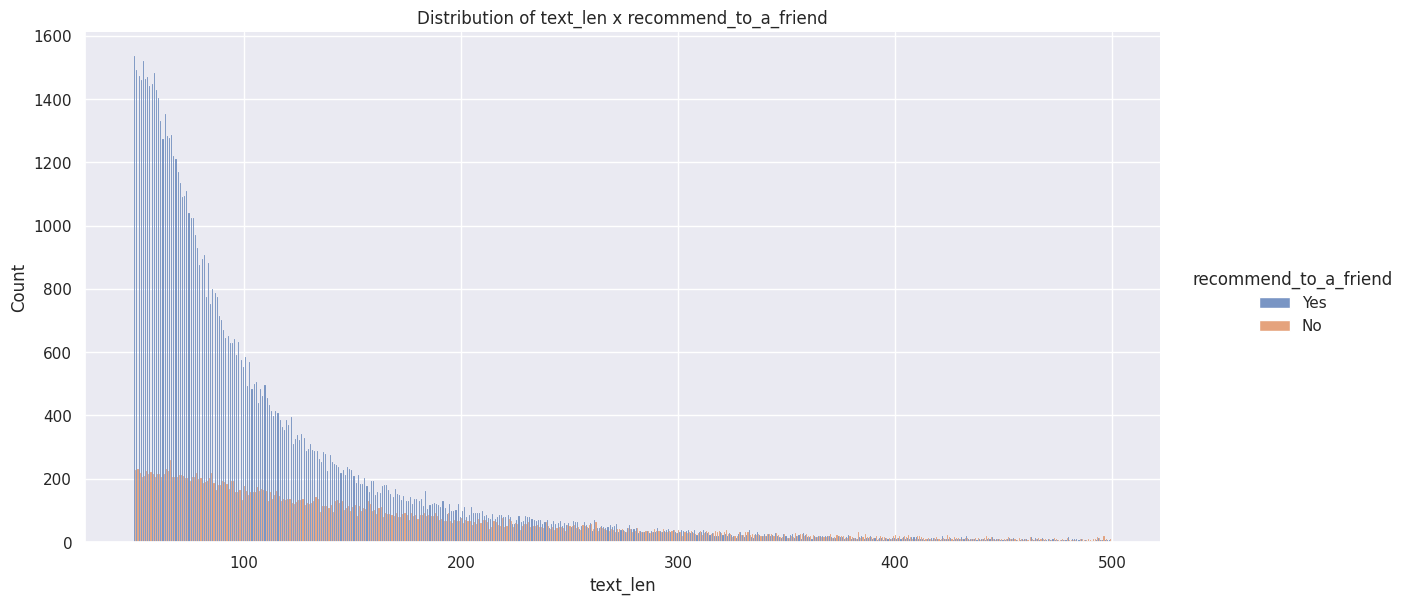

In [43]:
df_text_len = df_text[(df_text['text_len'] < 500)] 

sns.displot(data=df_text_len, 
            x="text_len", 
            hue='recommend_to_a_friend', 
            multiple="dodge", 
            discrete=True,
            height=6, aspect=2).set(title='Distribution of text_len x recommend_to_a_friend')

In [44]:
print('Yes')
print(df_text[(df_text['recommend_to_a_friend'] == 'Yes')]['text_len'].describe(),'\n')
print('No')
print(df_text[(df_text['recommend_to_a_friend'] == 'No')]['text_len'].describe())  

Yes
count    87965.000000
mean       118.275087
std        103.755562
min         50.000000
25%         65.000000
50%         86.000000
75%        131.000000
max       4134.000000
Name: text_len, dtype: float64 

No
count    30518.000000
mean       185.549610
std        157.130097
min         50.000000
25%         86.000000
50%        137.000000
75%        229.000000
max       3119.000000
Name: text_len, dtype: float64


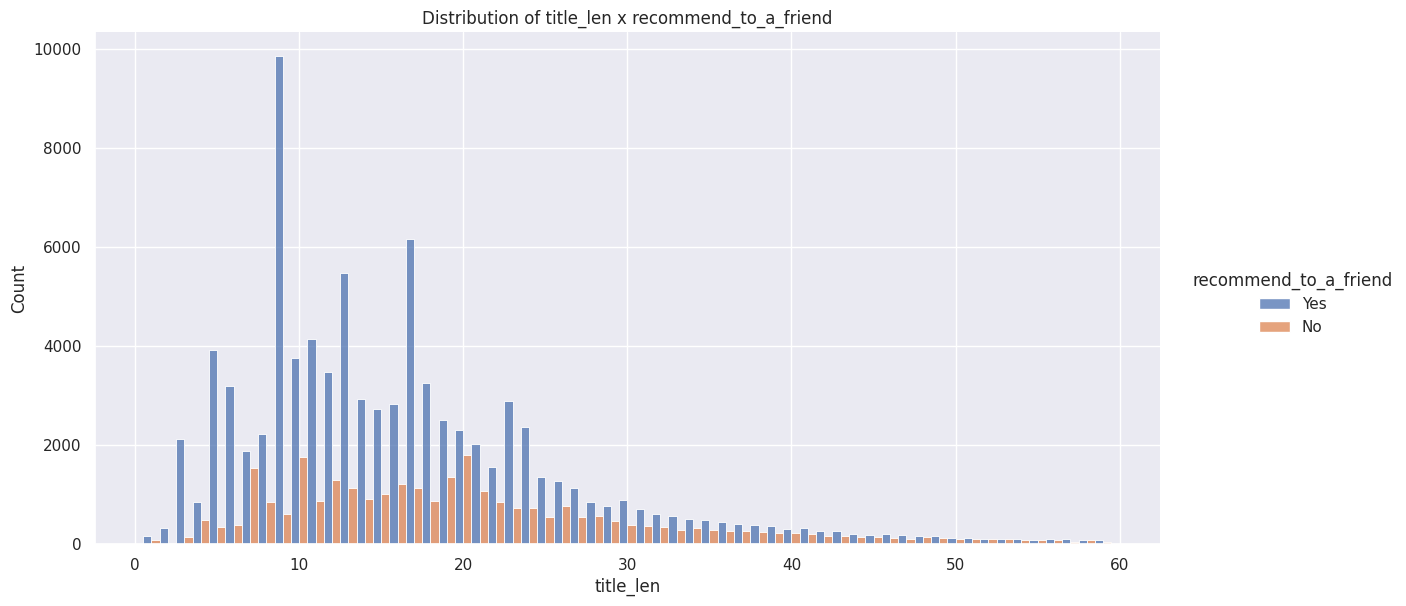

In [45]:
df_text_title_len = df_text[(df_text['title_len'] < 60)] 

sns.displot(data=df_text_title_len, 
            x="title_len", 
            hue='recommend_to_a_friend', 
            multiple="dodge", 
            discrete=True,
            height=6, aspect=2).set(title='Distribution of title_len x recommend_to_a_friend')

In [46]:
print('Yes')
print(df_text[(df_text['recommend_to_a_friend'] == 'Yes')]['title_len'].describe(),'\n')
print('No')
print(df_text[(df_text['recommend_to_a_friend'] == 'No')]['title_len'].describe())  

Yes
count    87965.000000
mean        17.174820
std         12.161651
min          1.000000
25%          9.000000
50%         14.000000
75%         21.000000
max        150.000000
Name: title_len, dtype: float64 

No
count    30518.000000
mean        22.528770
std         16.501524
min          1.000000
25%         12.000000
50%         19.000000
75%         27.000000
max        149.000000
Name: title_len, dtype: float64


**Insights:**
- Detractors in average write more both in the title as in the text

In [47]:
def top_n_ngram(corpus,n = None,ngram = 1):
    pt_stopwords = stopwords.words('portuguese')
    vec = CountVectorizer(stop_words=pt_stopwords, ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]

def plot_n_gram(corpus=df_text, column='review_text', n = 20,ngram = 1, title=None):
    common_words = top_n_ngram(corpus[column], n, ngram)
    df = pd.DataFrame(common_words, columns = [column , 'count'])
    plt.figure(figsize =(10,5))
    df.groupby(column).sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title=f'Top {n} {title} in review after removing stop words')

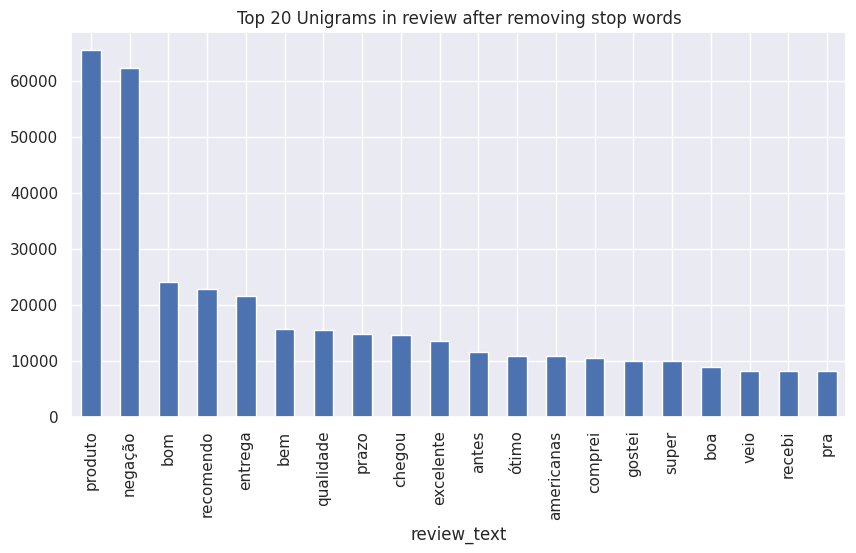

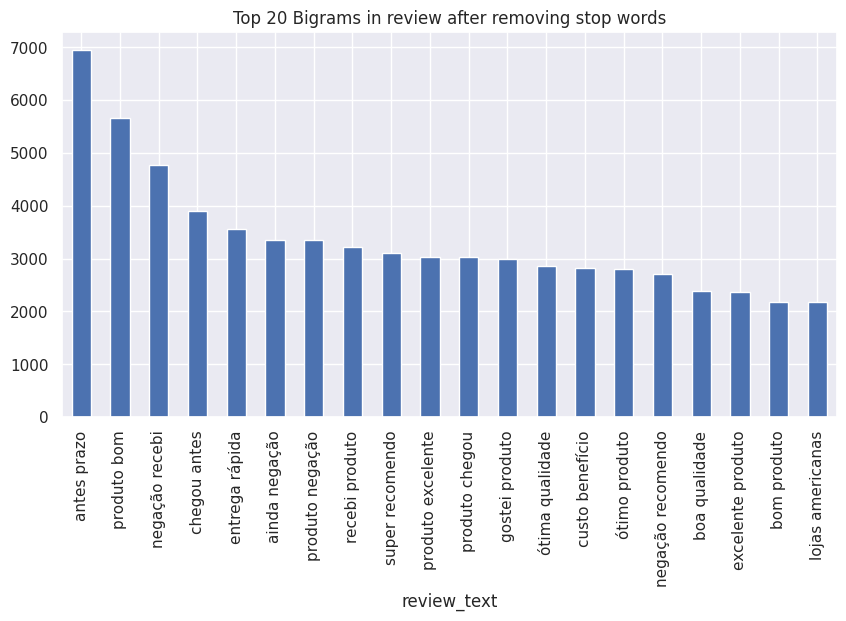

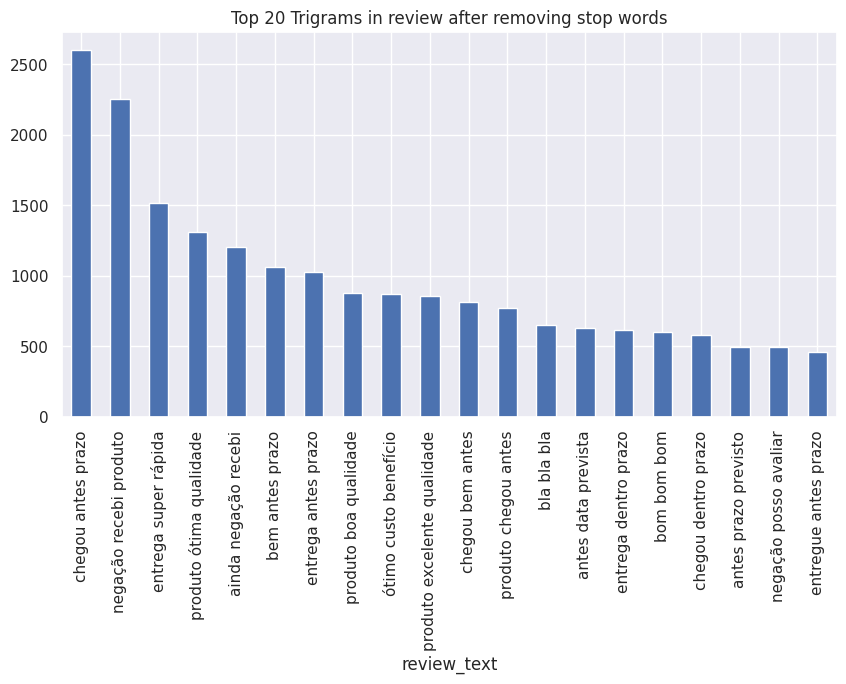

In [48]:
plot_n_gram(title='Unigrams')
plot_n_gram(ngram = 2, title='Bigrams')
plot_n_gram(ngram = 3, title='Trigrams')

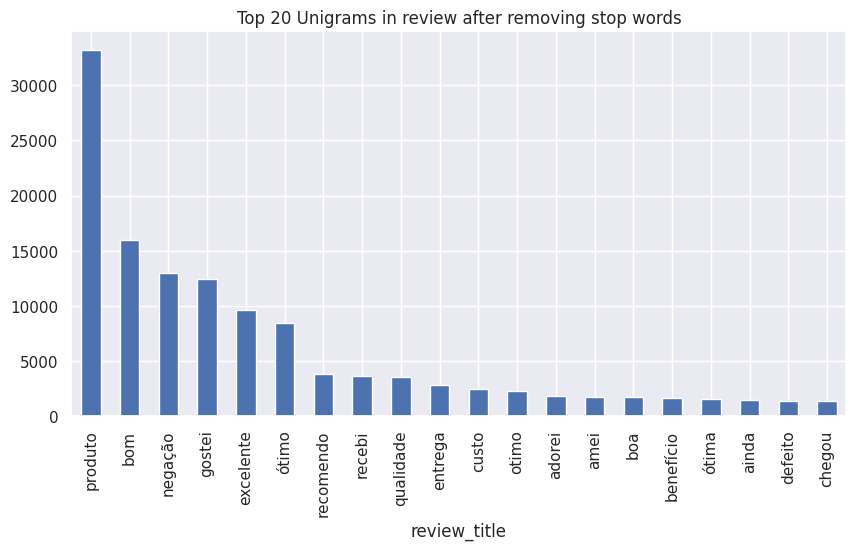

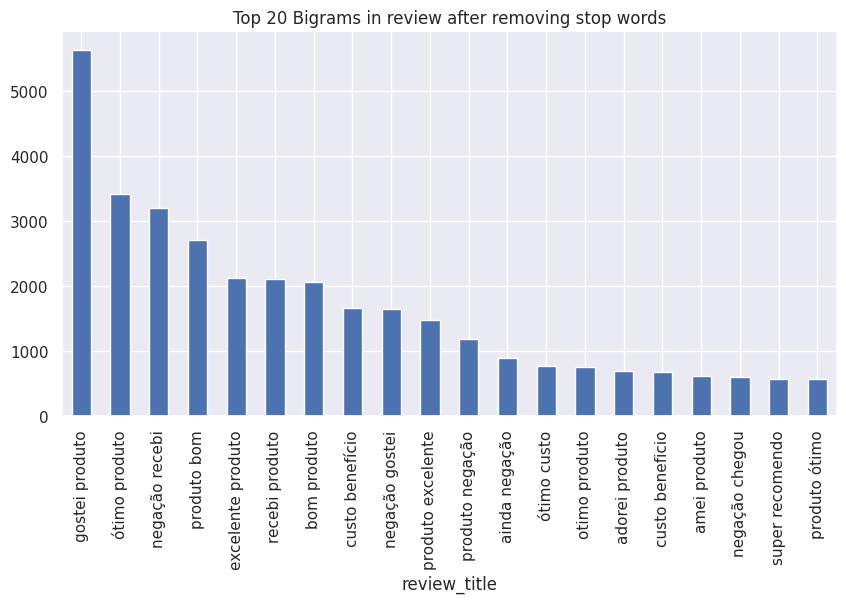

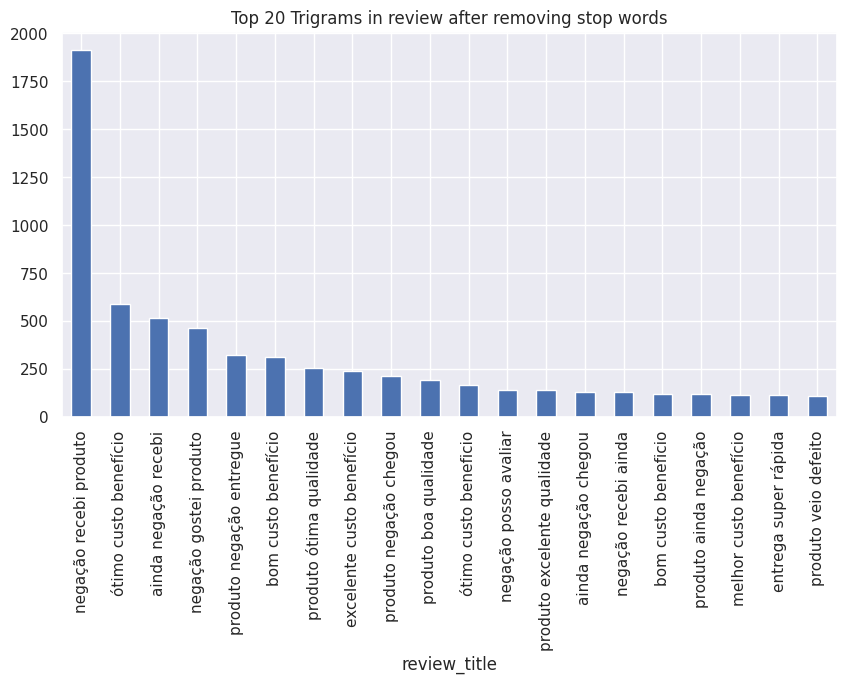

In [49]:
plot_n_gram(column='review_title', title='Unigrams')
plot_n_gram(column='review_title', ngram = 2, title='Bigrams')
plot_n_gram(column='review_title', ngram = 3, title='Trigrams')

**Merging review_text and review_title**

In [50]:
df_text['review_text'] = df_text['review_title'] + ' ' + df_text['review_text']
df_text.drop(columns=['review_title'], inplace=True)
df_text.head(5)

site_category_lv1       site_category_lv2  overall_rating  \
0            Informática                Notebook               4   
1  Utilidades Domésticas  Copos, Taças e Canecas               4   
2        Eletroportáteis         Panela Elétrica               4   
3             Brinquedos   Veículos de Brinquedo               4   
4      TV e Home Theater                      TV               5   

  recommend_to_a_friend                                        review_text  \
0                   Yes  bom estou contente com a compra entrega rápida...   
1                   Yes  preço imbatível ótima qualidade por apenas r e...   
2                   Yes  atende todas as expectativa  supera em agilida...   
3                   Yes  presente mais que desejado meu filho amou pare...   
4                   Yes  sem duvidas excelente a entrega foi no prazo a...   

   reviewer_birth_year reviewer_gender reviewer_state        date  text_len  \
0               1958.0               F             RJ  2018-01-01       158   
1               1996.0               M             SC  2018-01-01        69   
2               1984.0               M             SP  2018-01-01       236   
3               1985.0               F             SP  2018-01-01        62   
4               1994.0               M             MG  2018-01-01       202   

   title_len  
0          3  
1         32  
2         28  
3         26  
4         22

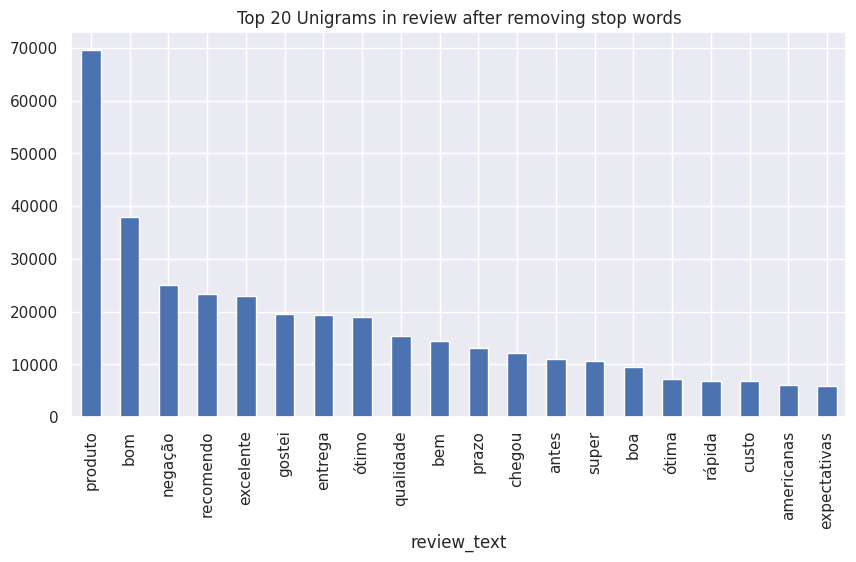

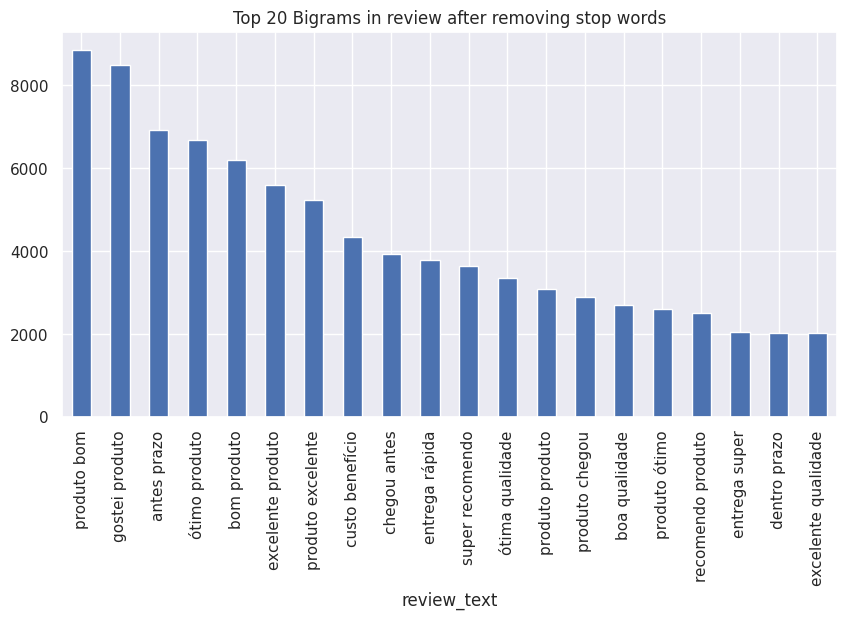

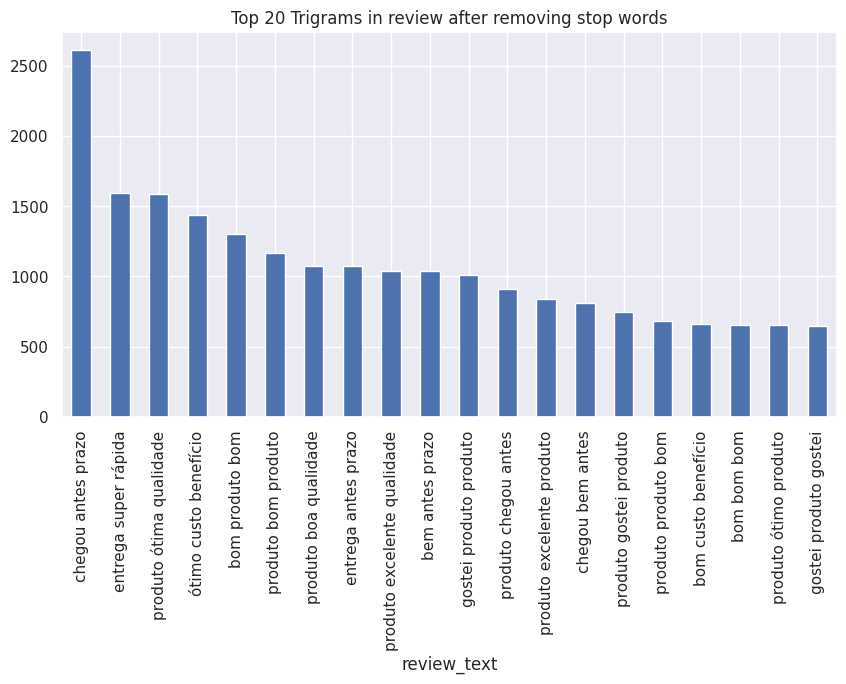

In [51]:
df_pos = df_text[df_text['recommend_to_a_friend']=='Yes']
plot_n_gram(corpus=df_pos, title='Unigrams')
plot_n_gram(corpus=df_pos, ngram = 2, title='Bigrams')
plot_n_gram(corpus=df_pos, ngram = 3, title='Trigrams')

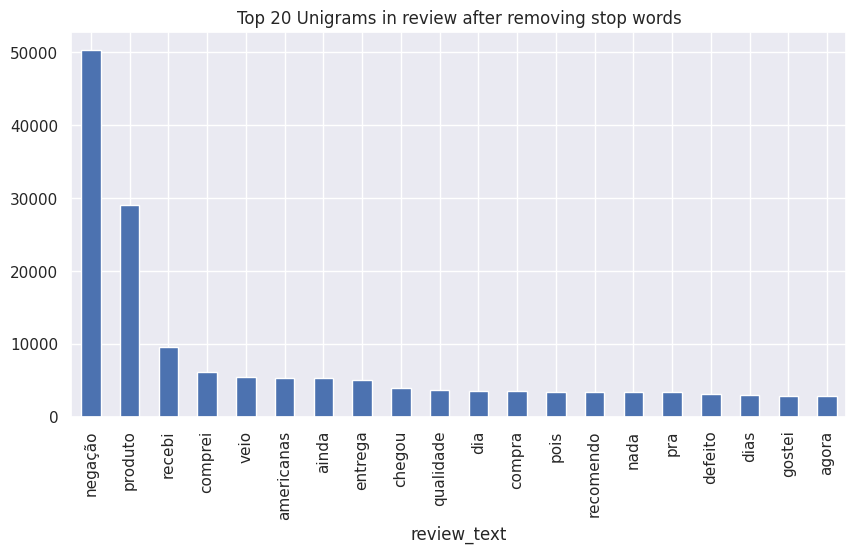

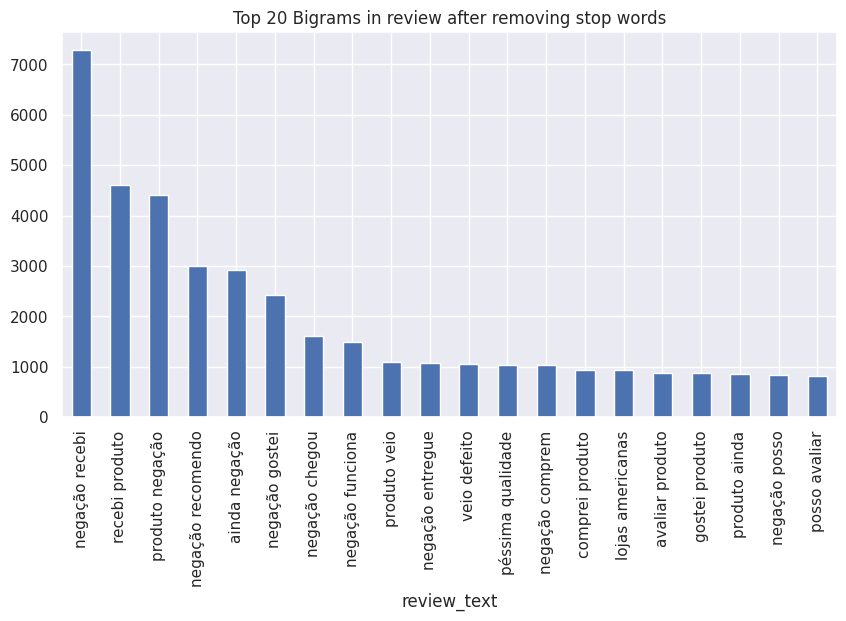

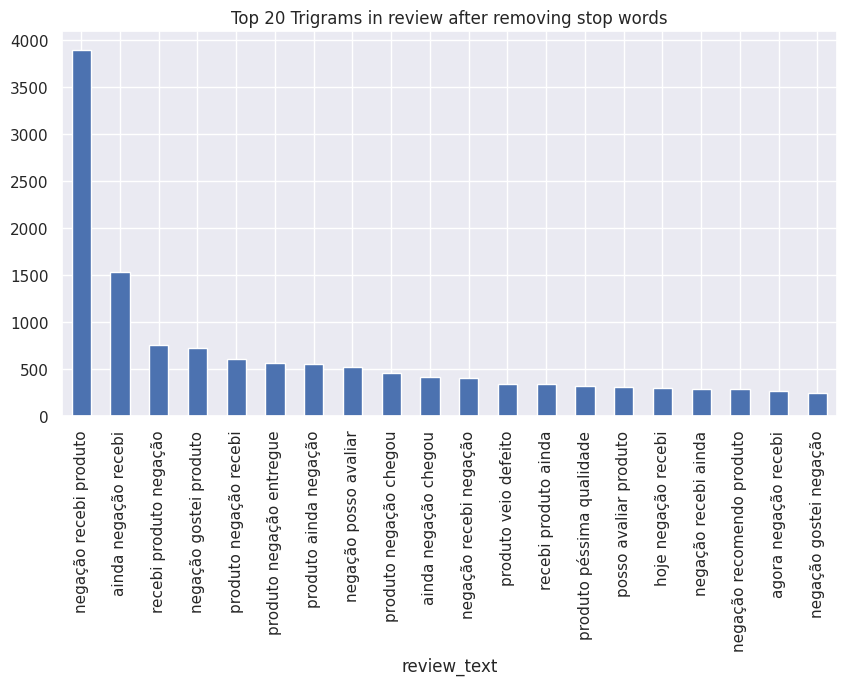

In [52]:
df_neg = df_text[df_text['recommend_to_a_friend']=='No']
plot_n_gram(corpus=df_neg, title='Unigrams')
plot_n_gram(corpus=df_neg, ngram = 2, title='Bigrams')
plot_n_gram(corpus=df_neg, ngram = 3, title='Trigrams')

In [53]:
print(df_text['text_len'].describe())

count    118483.000000
mean        135.603175
std         123.357746
min          50.000000
25%          68.000000
50%          95.000000
75%         154.000000
max        4134.000000
Name: text_len, dtype: float64


In [54]:
df_text[df_text['text_len']==50]['review_text'].values

array(['muito bom estão de parabéns só tenho que agradecer por vocês estão de parabéns',
       'loja lixo produto recusado porque chegou só depois do natal ',
       'gostei mas achei que viesse com mais um boneco coringa  o produto é resistente bem bolado e interessante ',
       ...,
       'ótimo produto recomendo  gostei muito do produto entrega rápida recomendo ',
       'boa muito boa a jarra podem confiar que é de qualidade',
       'tv excelente tv excelente custo benefício muito bom recomendo '],
      dtype=object)